In [264]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

In [265]:
raw = pd.read_excel("FTSE_Jan2005_Oct2021.xlsx")
raw.head(5)

,Date,Adj Close
0,2005-01-04,4847.000000
1,2005-01-05,4806.000000
2,2005-01-06,4824.299805
3,2005-01-07,4854.100098
4,2005-01-10,4840.700195


In [266]:
raw["Adj Close lag_1"] = raw["Adj Close"].shift(1)
raw["Rt"] = 100*np.log(raw["Adj Close"]/raw["Adj Close lag_1"])
raw.head()

,Date,Adj Close,Adj Close lag_1,Rt
0,2005-01-04,4847.000000,NaN,NaN
1,2005-01-05,4806.000000,4847.000000,-0.849482
2,2005-01-06,4824.299805,4806.000000,0.380047
3,2005-01-07,4854.100098,4824.299805,0.615812
4,2005-01-10,4840.700195,4854.100098,-0.276435


In [267]:
df = raw[["Date", "Rt"]].copy()
df = df.iloc[1:, :]
timestamp = [i for i in df.index]
df["time"] = timestamp
df.head()

,Date,Rt,time
1,2005-01-05,-0.849482,1
2,2005-01-06,0.380047,2
3,2005-01-07,0.615812,3
4,2005-01-10,-0.276435,4
5,2005-01-11,-0.455516,5


In [268]:
df.index = df["Date"]

### Stationary Test

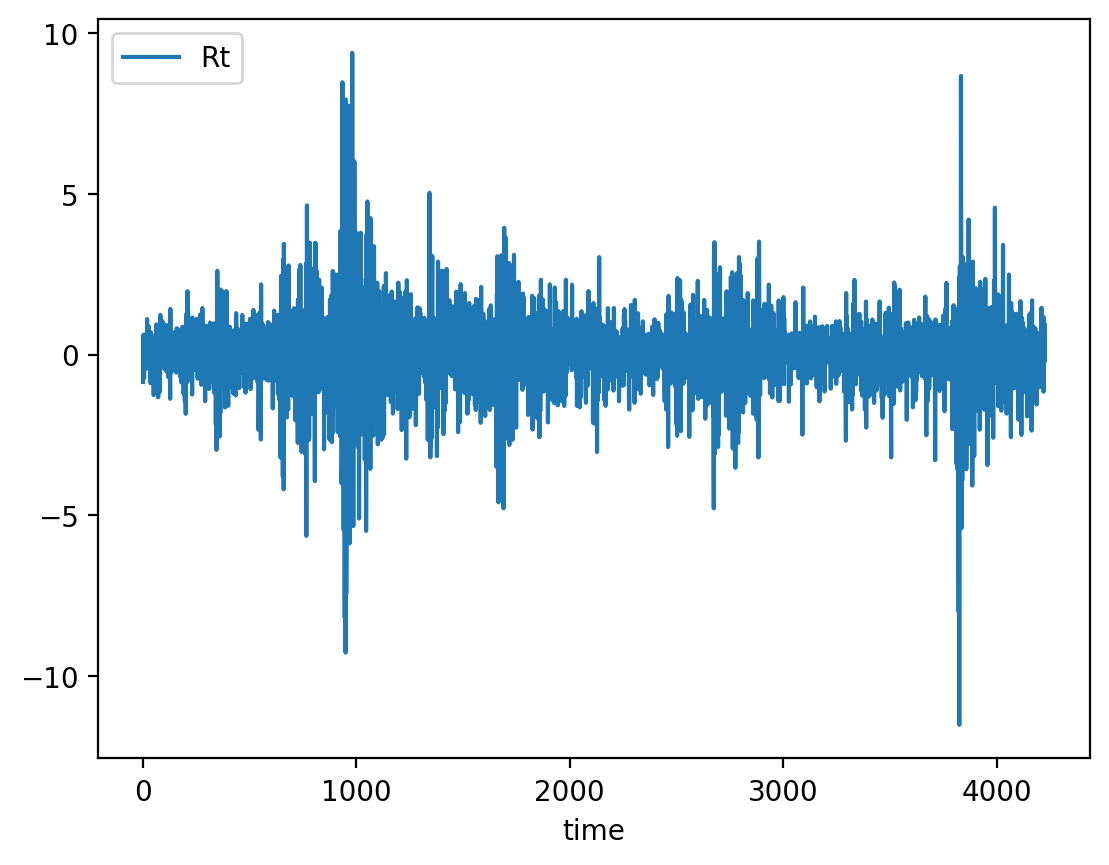

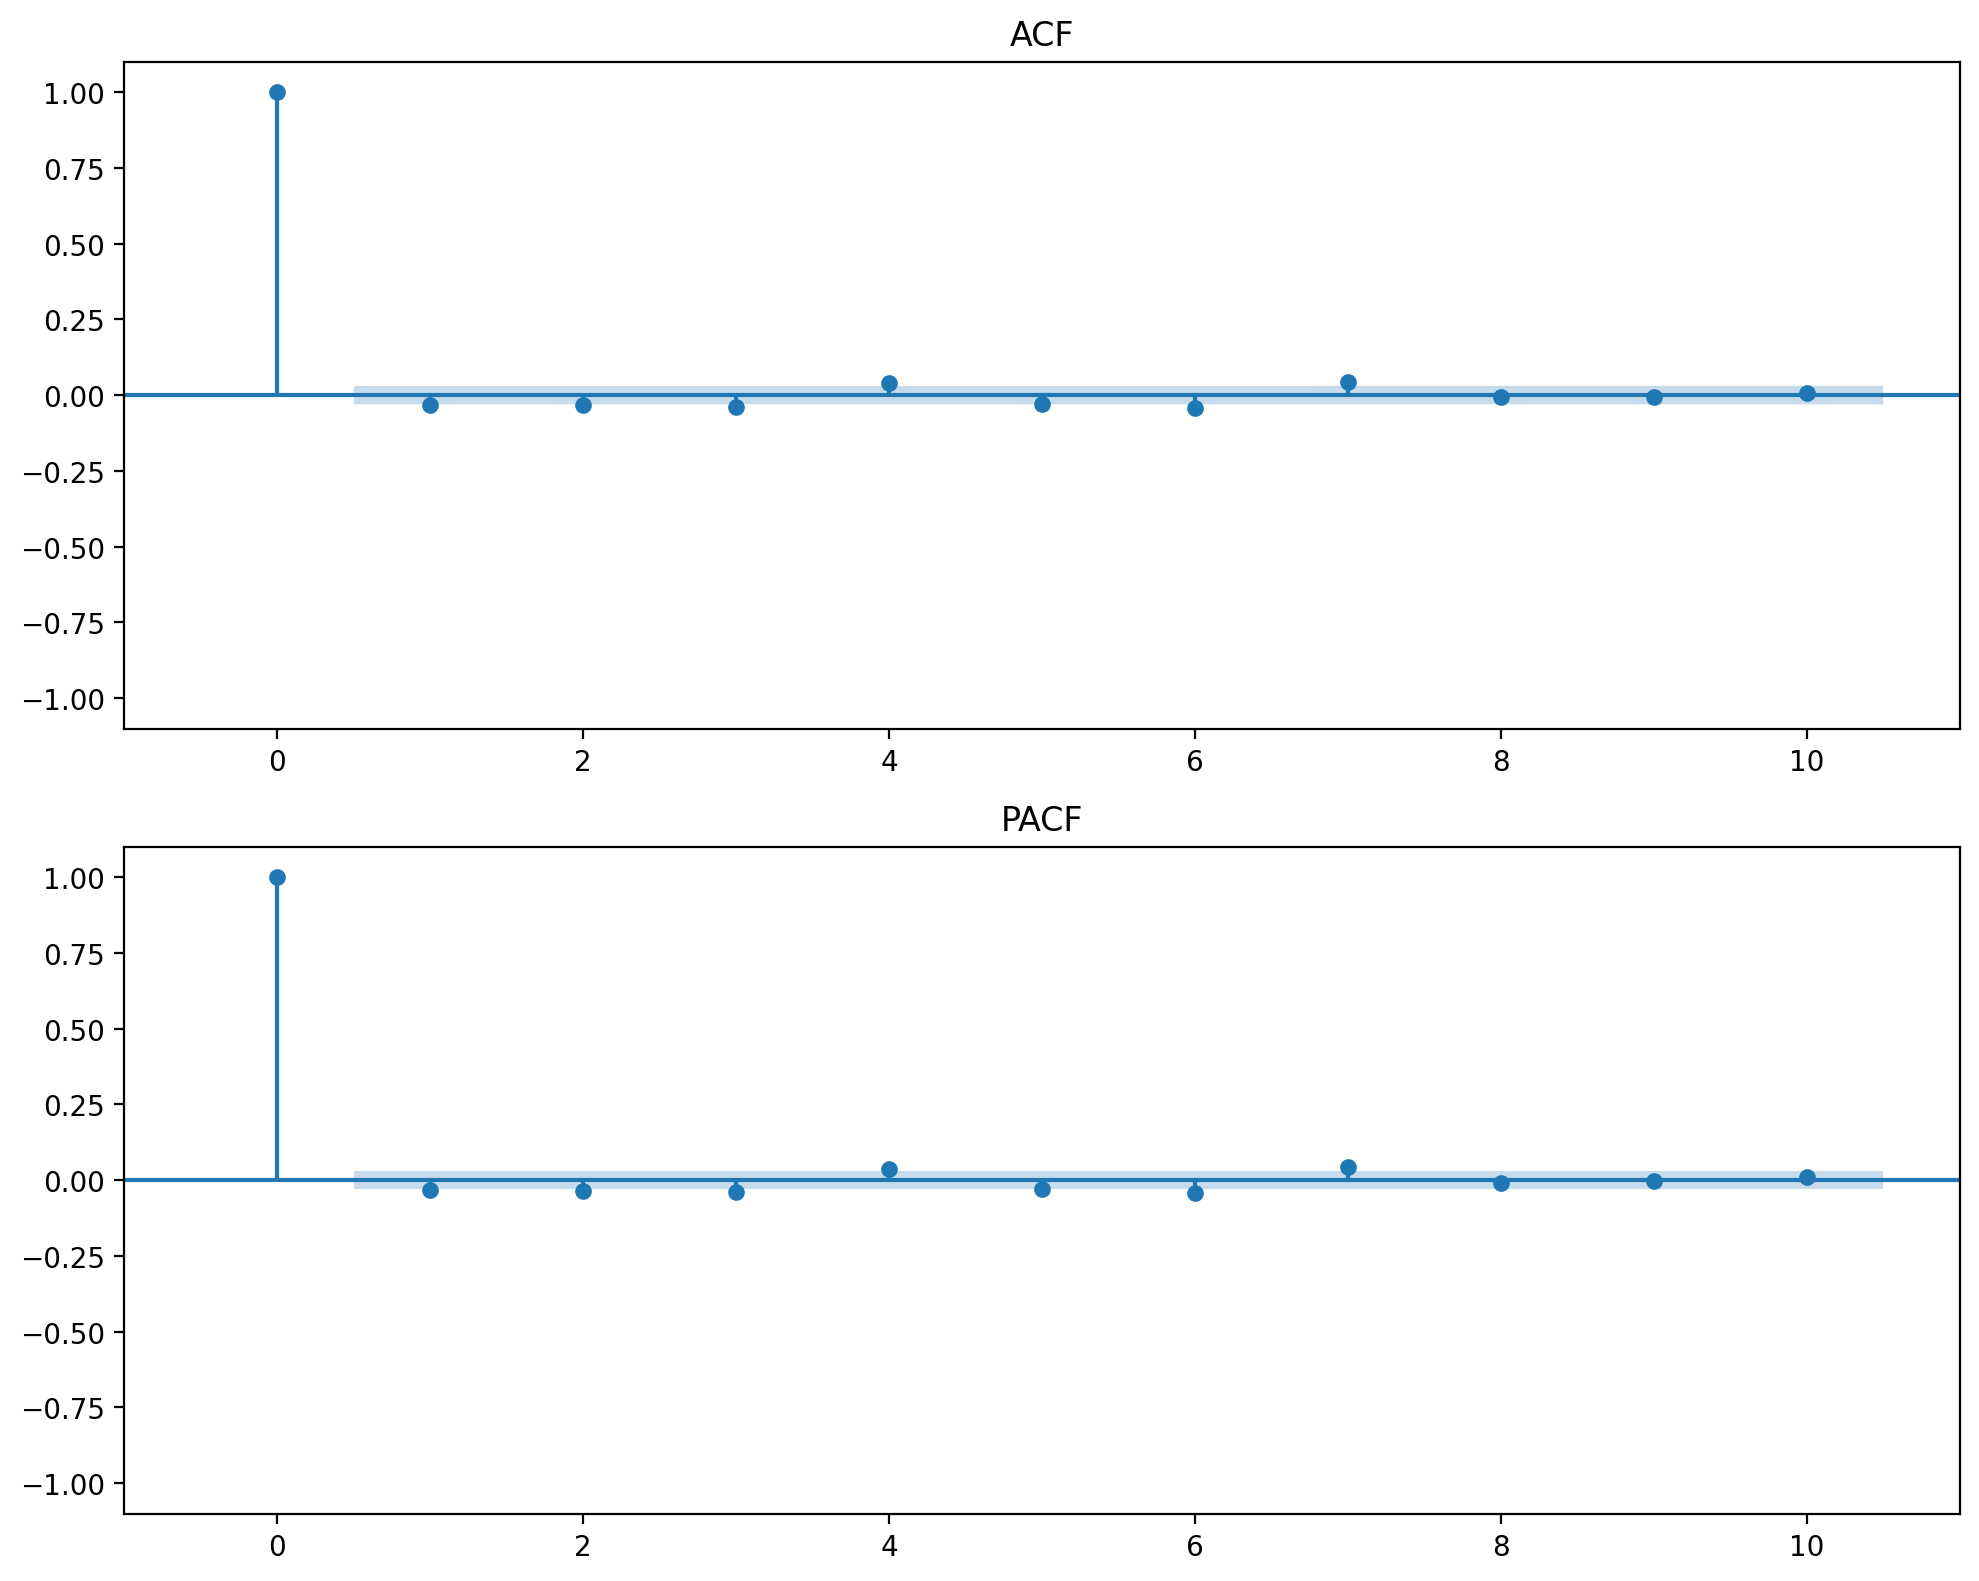

In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



df.plot(x='time', y='Rt')
plt.show()

# ACF/PACF 
plt.figure(figsize=(10, 8))
sm.graphics.tsa.plot_acf(df.Rt, lags=10, ax=plt.subplot(211))
plt.xlim(-1, 11)
plt.ylim(-1.1, 1.1)
plt.title("ACF")

sm.graphics.tsa.plot_pacf(df.Rt, lags=10, ax=plt.subplot(212))
plt.xlim(-1, 11)
plt.ylim(-1.1, 1.1)
plt.title("PACF")
plt.tight_layout()
plt.show()

Stationary Check

In [356]:
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss


In [357]:
stationarity_adf_test(df, ["Rt"])

,Stationarity_adf
Test Statistics,-25.148918
p-value,0.000000
Used Lag,6.000000
Used Observations,4219.000000
Critical Value(1%),-3.431901
Maximum Information Criteria,13156.232236


ADF Test shows 'can reject the null hypothesis'. It means "**stationary**". 

In [272]:
stationarity_kpss_test(df, ["Rt"])

,Stationarity_kpss
Test Statistics,0.031065
p-value,0.100000
Used Lag,21.000000
Critical Value(10%),0.347000


KPSS Test shows 'cannot reject the null hypothesis'. It means "**stationary**". 

### Model Identification

Conclusion with KPSS test : Stationary

In [273]:
import statsmodels.api as sm
from pmdarima.arima import ndiffs
import pmdarima as pm

In [274]:
# Sample Modeling with simple model
# MA(1) Modeling
fit = sm.tsa.arima.ARIMA(df.Rt, order =(0, 0, 1)).fit()
display(fit.summary())

# AR(1) Modeling
fit = sm.tsa.arima.ARIMA(df.Rt, order = (1, 0, 0)).fit()
display(fit.summary())

# ARMA(1,1) Modeling
fit = sm.tsa.arima.ARIMA(df.Rt, order = (1, 0,1)).fit()
display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     Rt   No. Observations:                 4226
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -6625.290
Date:                Sun, 12 Dec 2021   AIC                          13256.581
Time:                        17:58:08   BIC                          13275.628
Sample:                             0   HQIC                         13263.314
                               - 4226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0094      0.018      0.530      0.596      -0.025       0.044
ma.L1         -0.0363      0.008     -4.355      0.000      -0.053      -0.020
sigma2         1.3466      0.012    112.035      0.000       1.323       1.370
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             18225.20
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     Rt   No. Observations:                 4226
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -6625.475
Date:                Sun, 12 Dec 2021   AIC                          13256.949
Time:                        17:58:08   BIC                          13275.996
Sample:                             0   HQIC                         13263.682
                               - 4226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0094      0.018      0.530      0.596      -0.025       0.044
ar.L1         -0.0337      0.008     -4.040      0.000      -0.050      -0.017
sigma2         1.3467      0.012    112.100      0.000       1.323       1.370
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             18236.77
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     Rt   No. Observations:                 4226
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -6621.560
Date:                Sun, 12 Dec 2021   AIC                          13251.120
Time:                        17:58:09   BIC                          13276.517
Sample:                             0   HQIC                         13260.098
                               - 4226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0094      0.018      0.534      0.594      -0.025       0.044
ar.L1          0.6683      0.081      8.248      0.000       0.510       0.827
ma.L1         -0.7090      0.076     -9.372      0.000      -0.857      -0.561
sigma2         1.3442      0.012    111.443      0.000       1.321       1.368
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):             18710.80
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Parameter Estimation with diverse trials

In [363]:
kpss_diffs = ndiffs(df.Rt, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(df.Rt, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Check the optimal diff d = {n_diffs}")

Check the optimal diff d = 0


No need to difference. 

Choose the optimal Paramete

,p,q,LLF,AIC,BIC
0,1,0,-6625.474542,13256.949084,13275.996118
1,1,1,-6621.560234,13251.120468,13276.516512
2,1,2,-6621.274863,13252.549725,13284.294781
3,1,3,-6616.931967,13245.863934,13283.958001
4,2,0,-6622.915616,13253.831232,13279.227276
5,2,1,-6621.260128,13252.520256,13284.265312
6,2,2,-6619.526751,13251.053503,13289.147570
7,2,3,-6609.649002,13233.298004,13277.741083
8,3,0,-6619.421422,13248.842845,13280.587901
9,3,1,-6617.336140,13246.672280,13284.766348


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     Rt   No. Observations:                 4226
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -6609.649
Date:                Sun, 12 Dec 2021   AIC                          13233.298
Time:                        18:24:32   BIC                          13277.741
Sample:                             0   HQIC                         13249.008
                               - 4226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0094      0.017      0.542      0.588      -0.024       0.043
ar.L1         -0.7680      0.060    -12.776      0.000      -0.886      -0.650
ar.L2         -0.6338      0.058    -10.855      0.000      -0.748      -0.519
ma.L1          0.7354      0.062     11.851      0.000       0.614       0.857
ma.L2          0.5747      0.060      9.534      0.000       0.457       0.693
ma.L3         -0.0878      0.009     -9.954      0.000      -0.105      -0.071
sigma2         1.3367      0.013    104.263      0.000       1.312       1.362
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17087.72
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

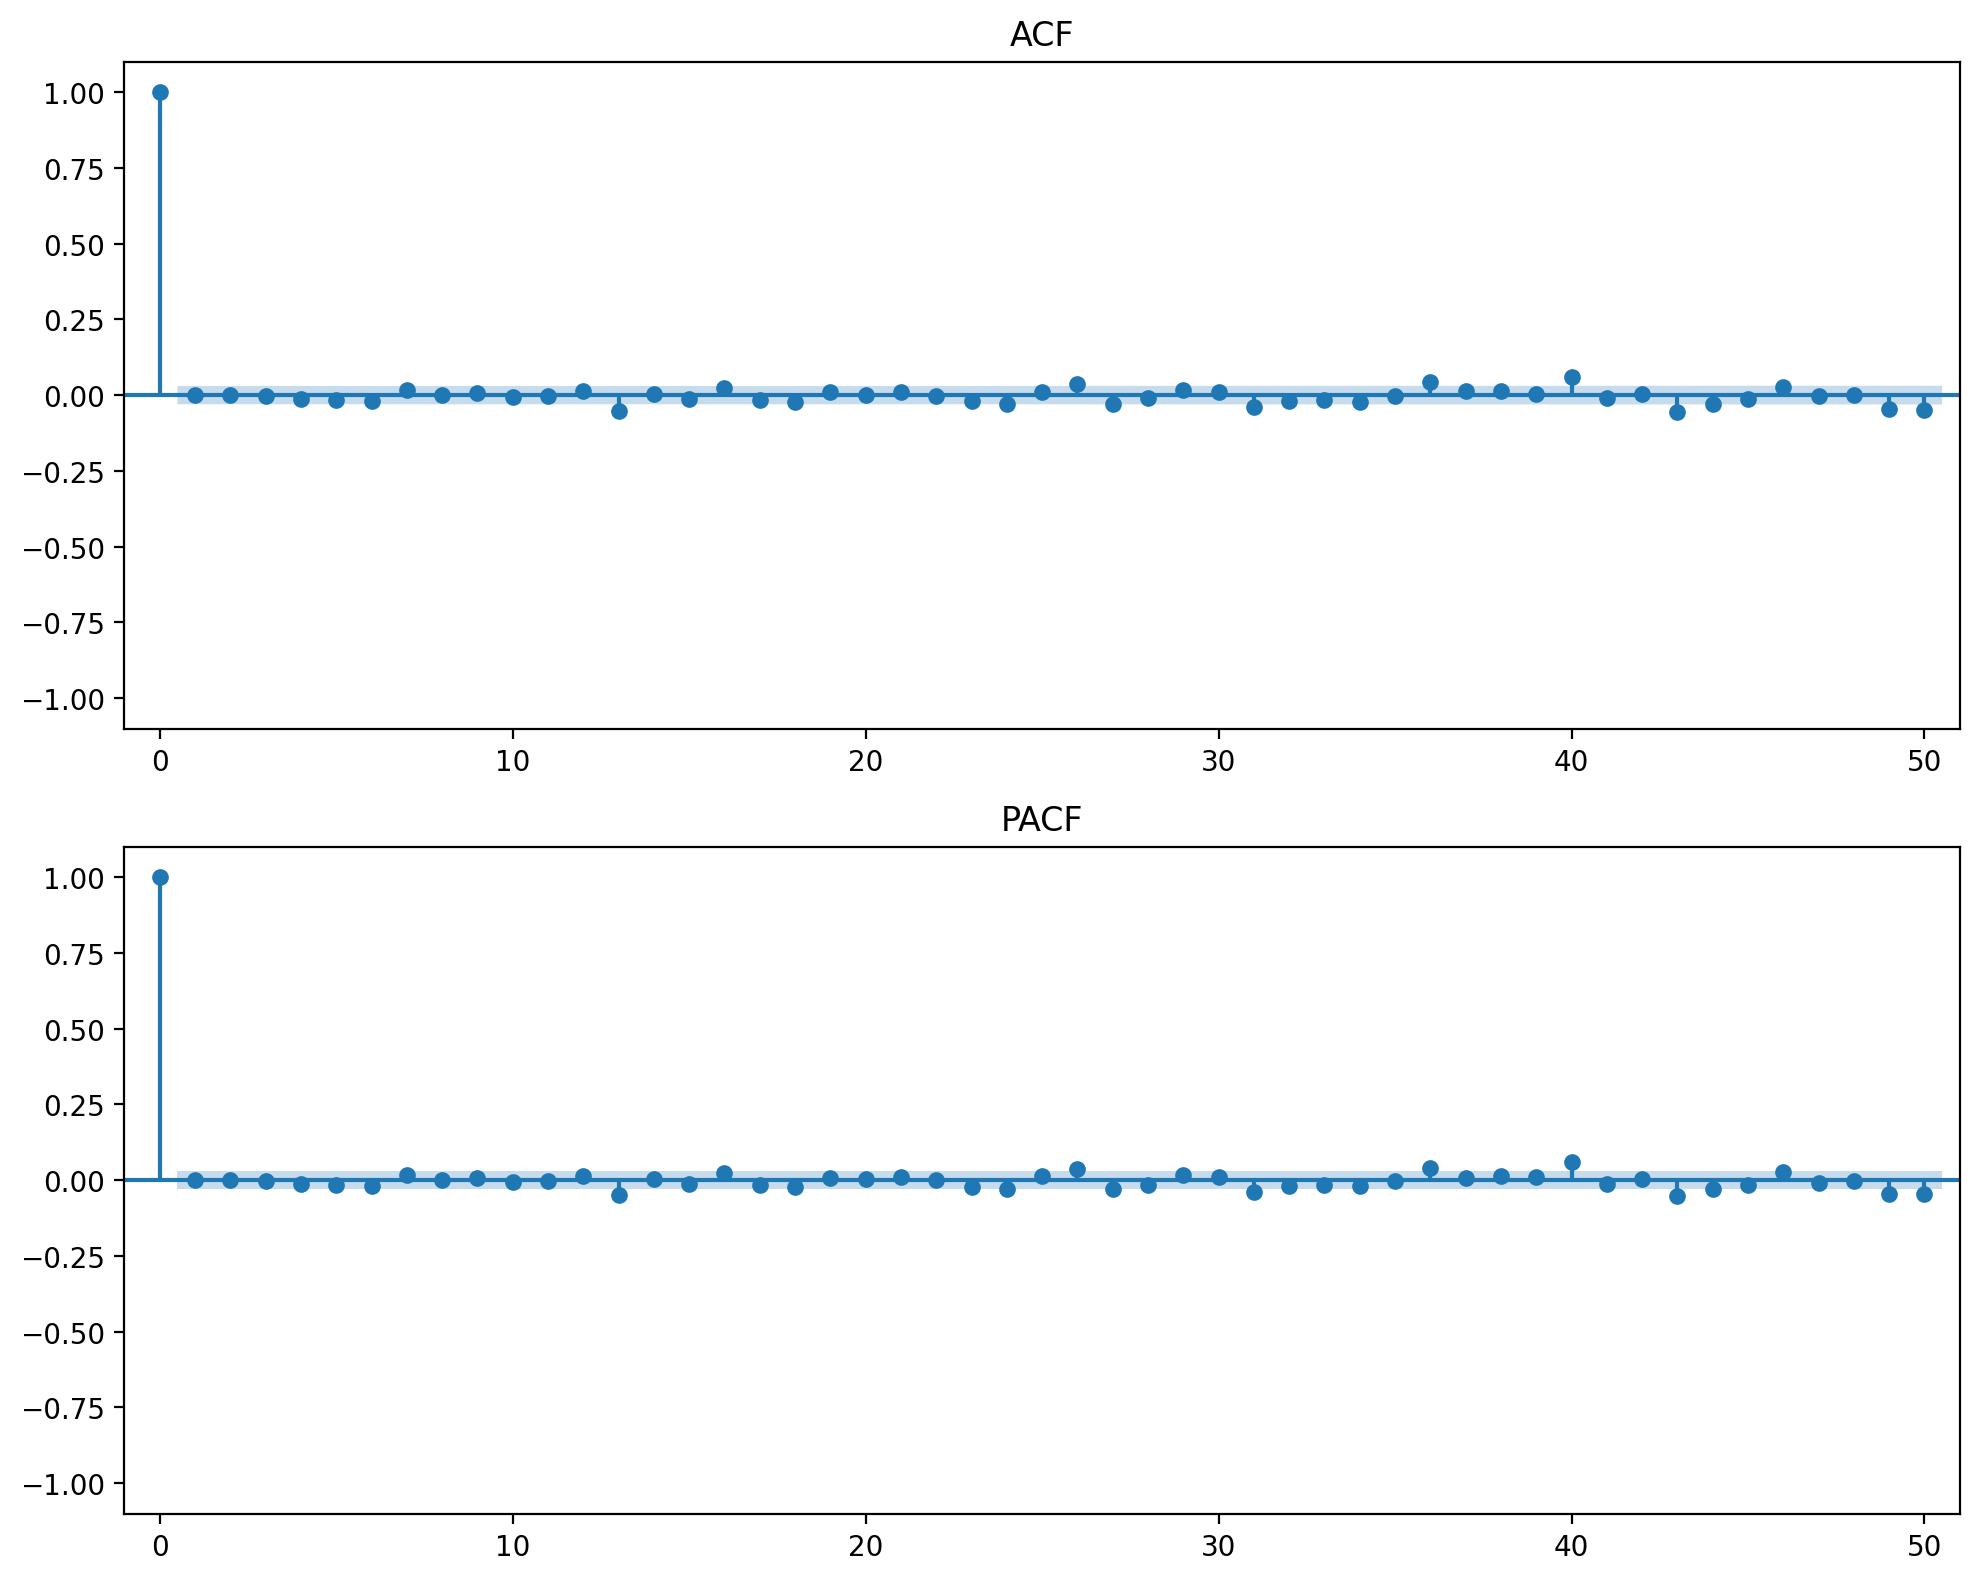

In [364]:
from itertools import product
result = []
for p, q in product(range(4), range(4)):
    if (p == 0 & q == 0):
        continue
    model = sm.tsa.arima.ARIMA(df.Rt, order = (p, 0, q)).fit()
    try:
        result.append({"p": p, "q": q, "LLF": model.llf, "AIC": model.aic, "BIC": model.bic})
    except:
        pass
   
# Model Optimal paramter 
result = pd.DataFrame(result)
display(result)
opt_ar = result.iloc[np.argmin(result['AIC']), 0]
opt_ma = result.iloc[np.argmin(result['AIC']), 1]

# ARMA Modeling
fit = sm.tsa.arima.ARIMA(df.Rt, order = (opt_ar, 0 ,opt_ma)).fit()
display(fit.summary())

# Residual ACF/PACF Check
plt.figure(figsize=(10, 8))
sm.graphics.tsa.plot_acf(fit.resid, lags=50, ax=plt.subplot(211))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("ACF")

sm.graphics.tsa.plot_pacf(fit.resid, lags=50, ax=plt.subplot(212))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("PACF")
plt.tight_layout()
plt.show()

Residual Test

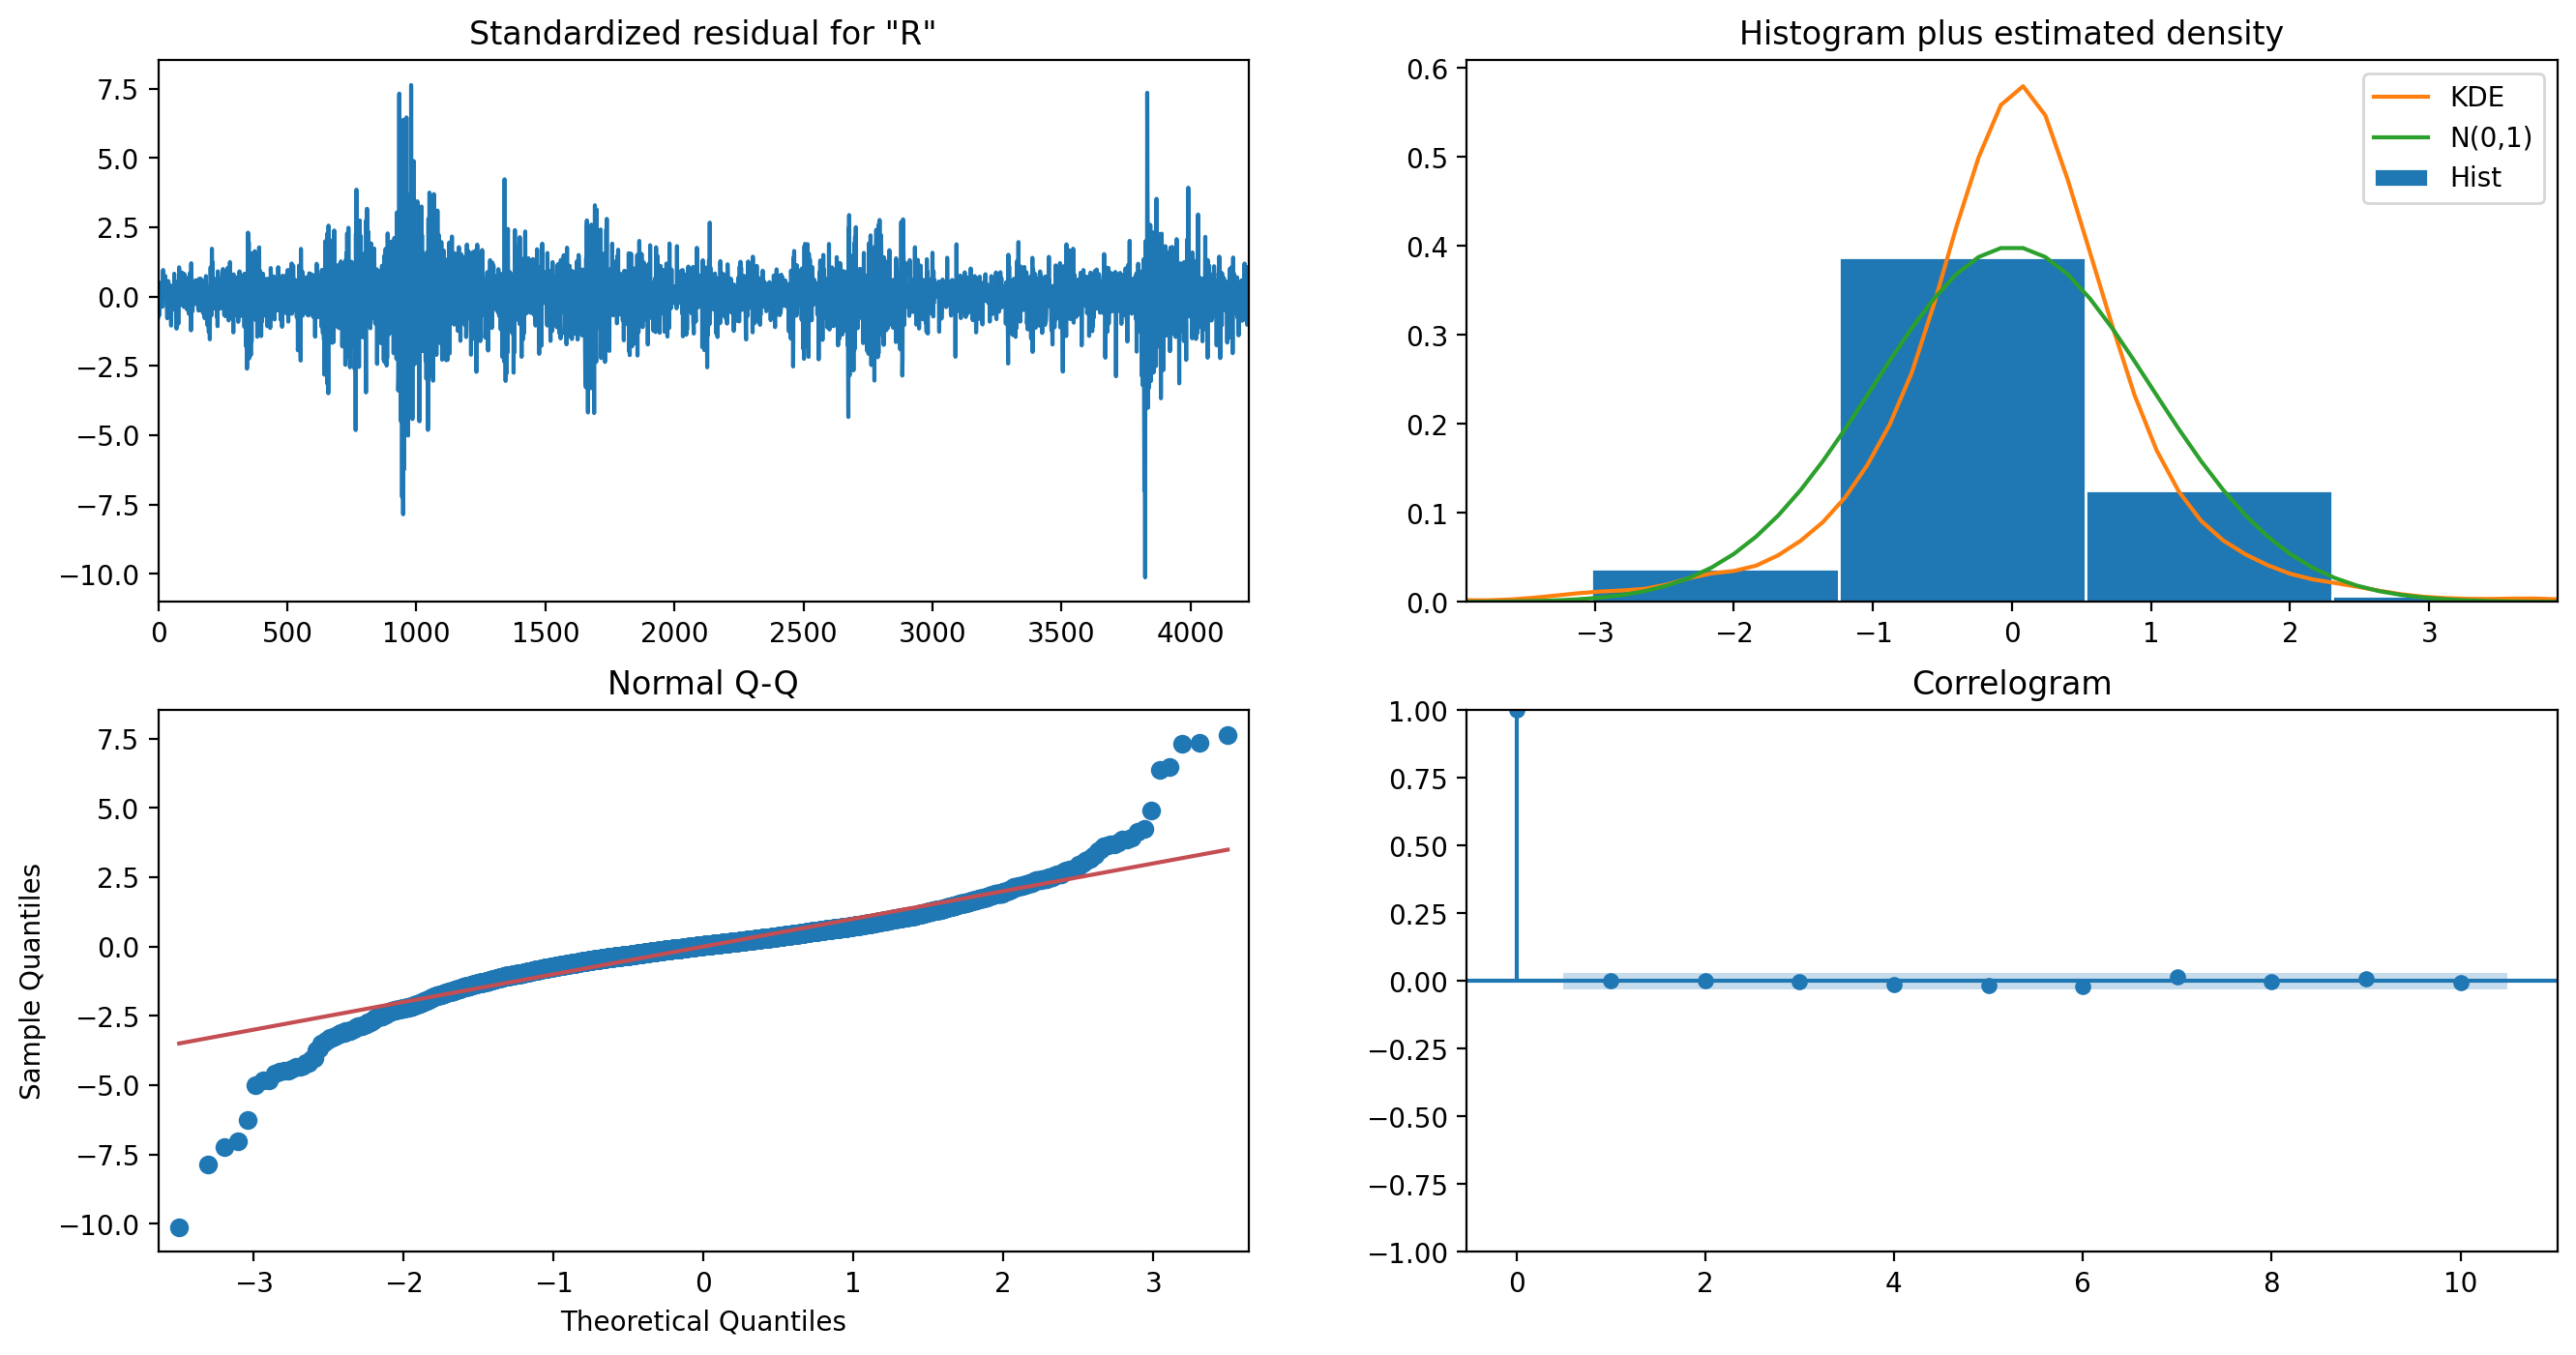

In [366]:
fit.plot_diagnostics(figsize=(16, 8))
plt.show()

In [374]:
model = sm.tsa.arima.ARIMA(df.Rt, order = (2, 0, 3)).fit()
display(model.summary())
pred_tr_ts_arima = model.predict()
pred_te_ts_arima = model.get_forecast(len(df.Rt)).predicted_mean
pred_te_ts_arima_ci = model.get_forecast(len(df.Rt)).conf_int()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     Rt   No. Observations:                 4226
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -6609.649
Date:                Sun, 12 Dec 2021   AIC                          13233.298
Time:                        18:25:55   BIC                          13277.741
Sample:                             0   HQIC                         13249.008
                               - 4226                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0094      0.017      0.542      0.588      -0.024       0.043
ar.L1         -0.7680      0.060    -12.776      0.000      -0.886      -0.650
ar.L2         -0.6338      0.058    -10.855      0.000      -0.748      -0.519
ma.L1          0.7354      0.062     11.851      0.000       0.614       0.857
ma.L2          0.5747      0.060      9.534      0.000       0.457       0.693
ma.L3         -0.0878      0.009     -9.954      0.000      -0.105      -0.071
sigma2         1.3367      0.013    104.263      0.000       1.312       1.362
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17087.72
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [375]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

,MAE,MSE,MAPE
Train,0.779867,1.336701,inf
Test,0.779110,1.348263,inf


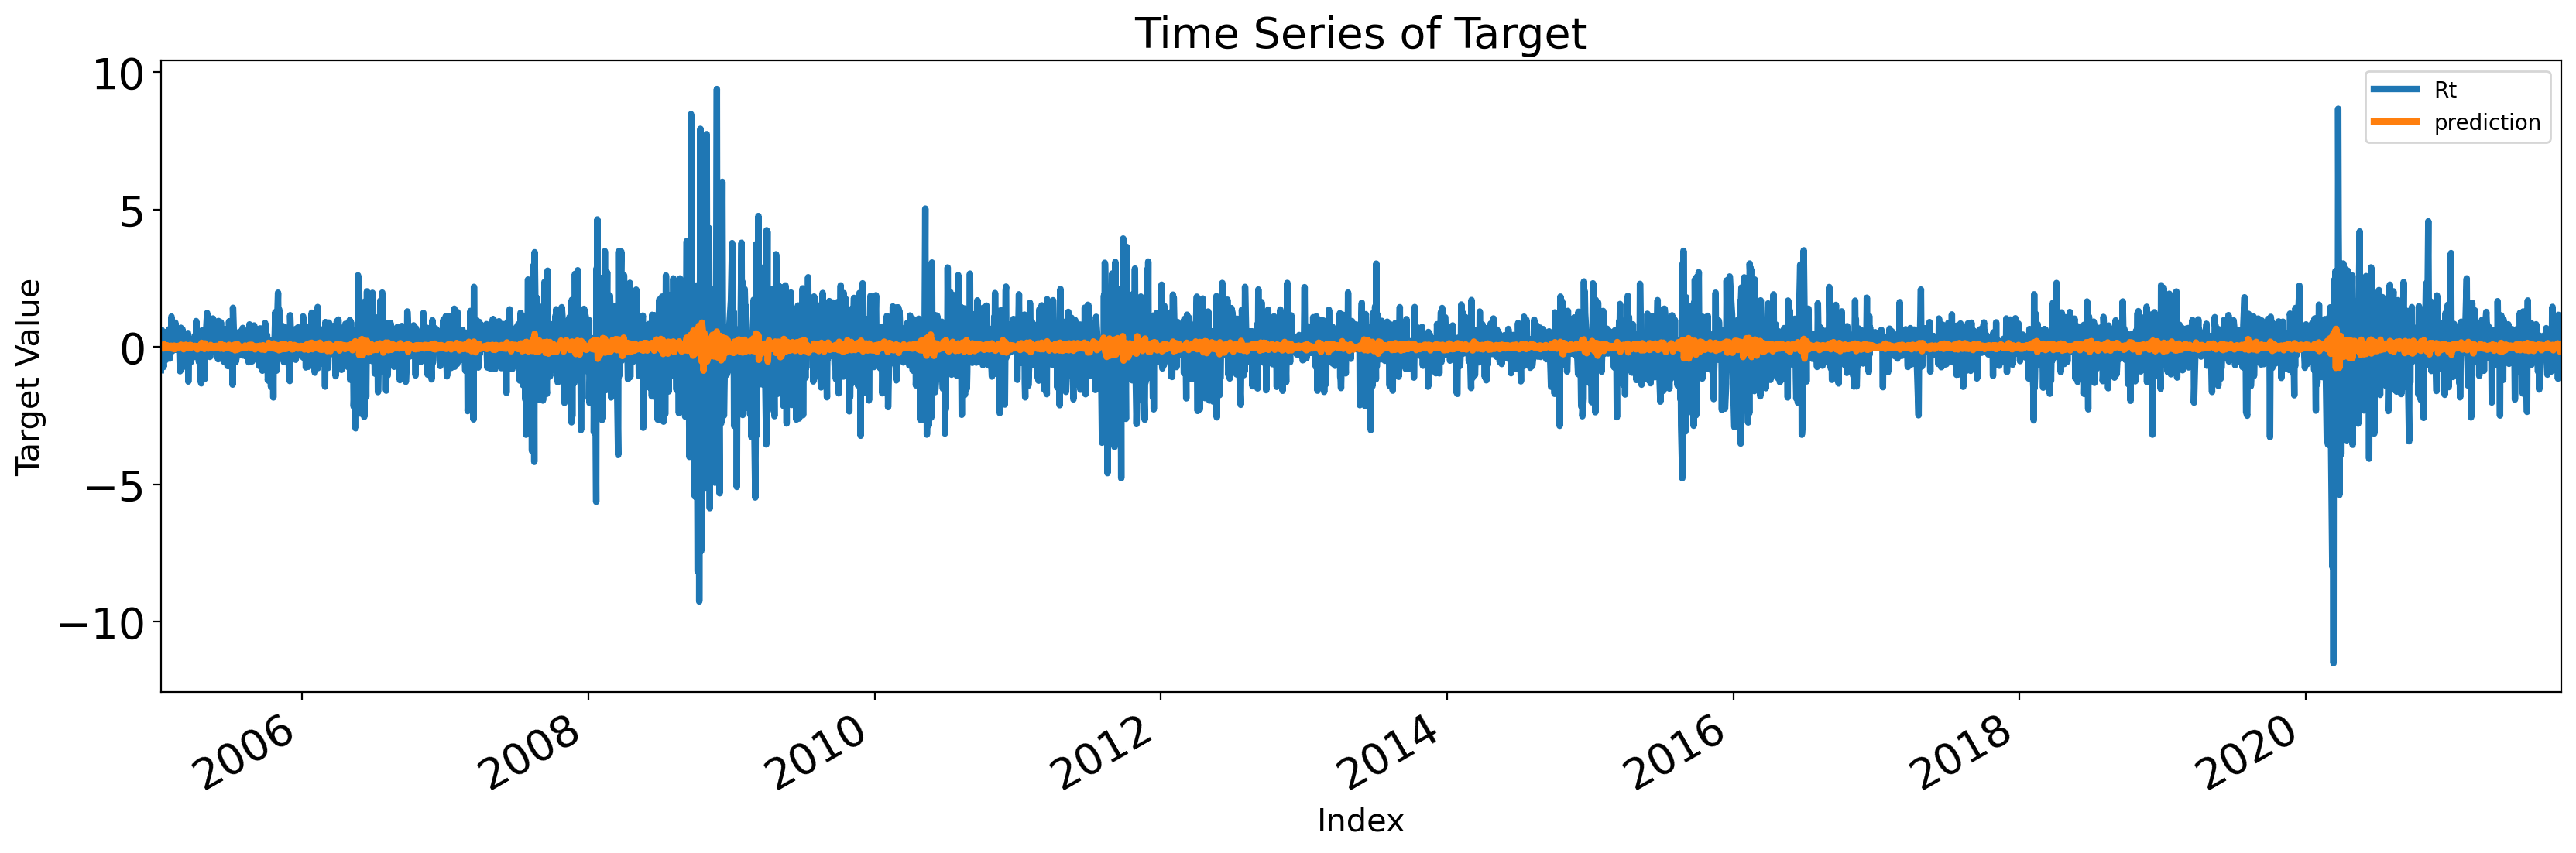

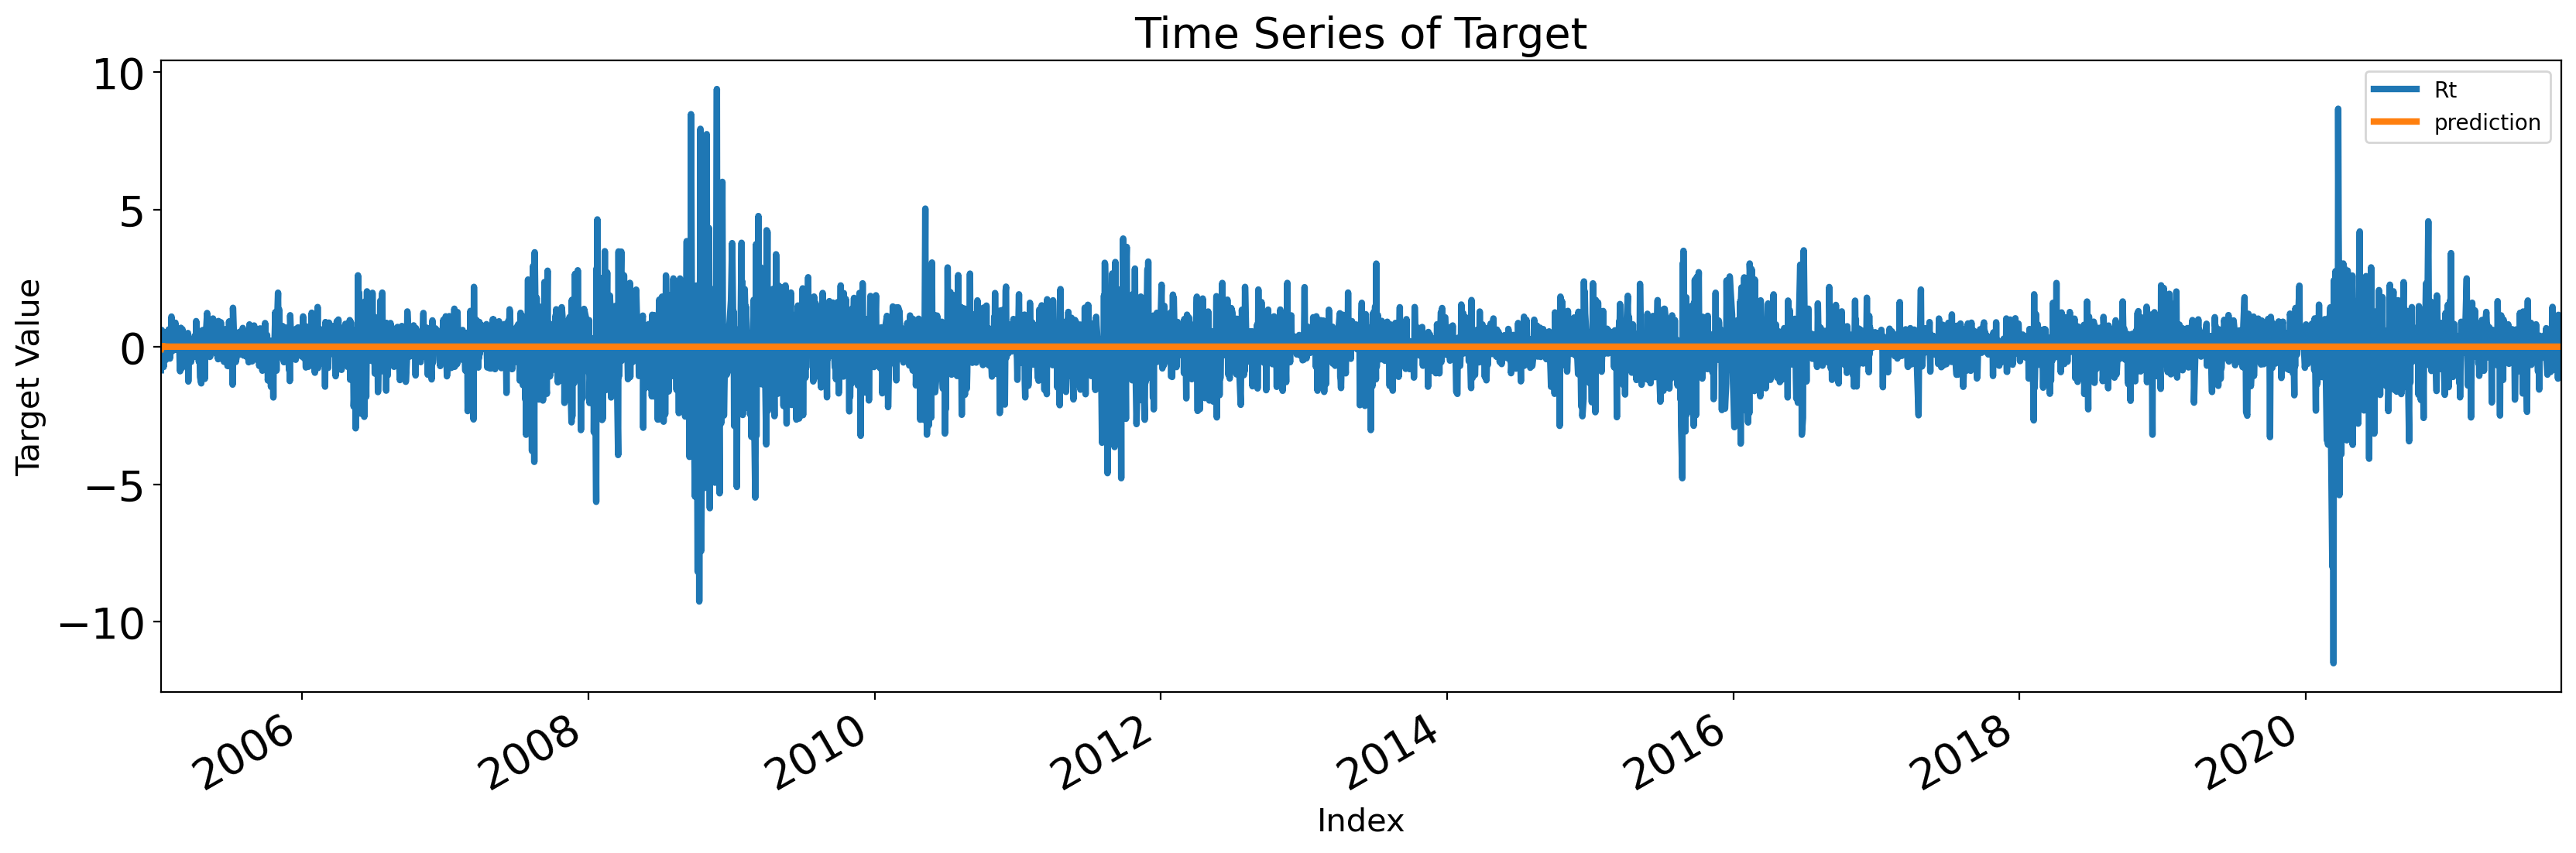

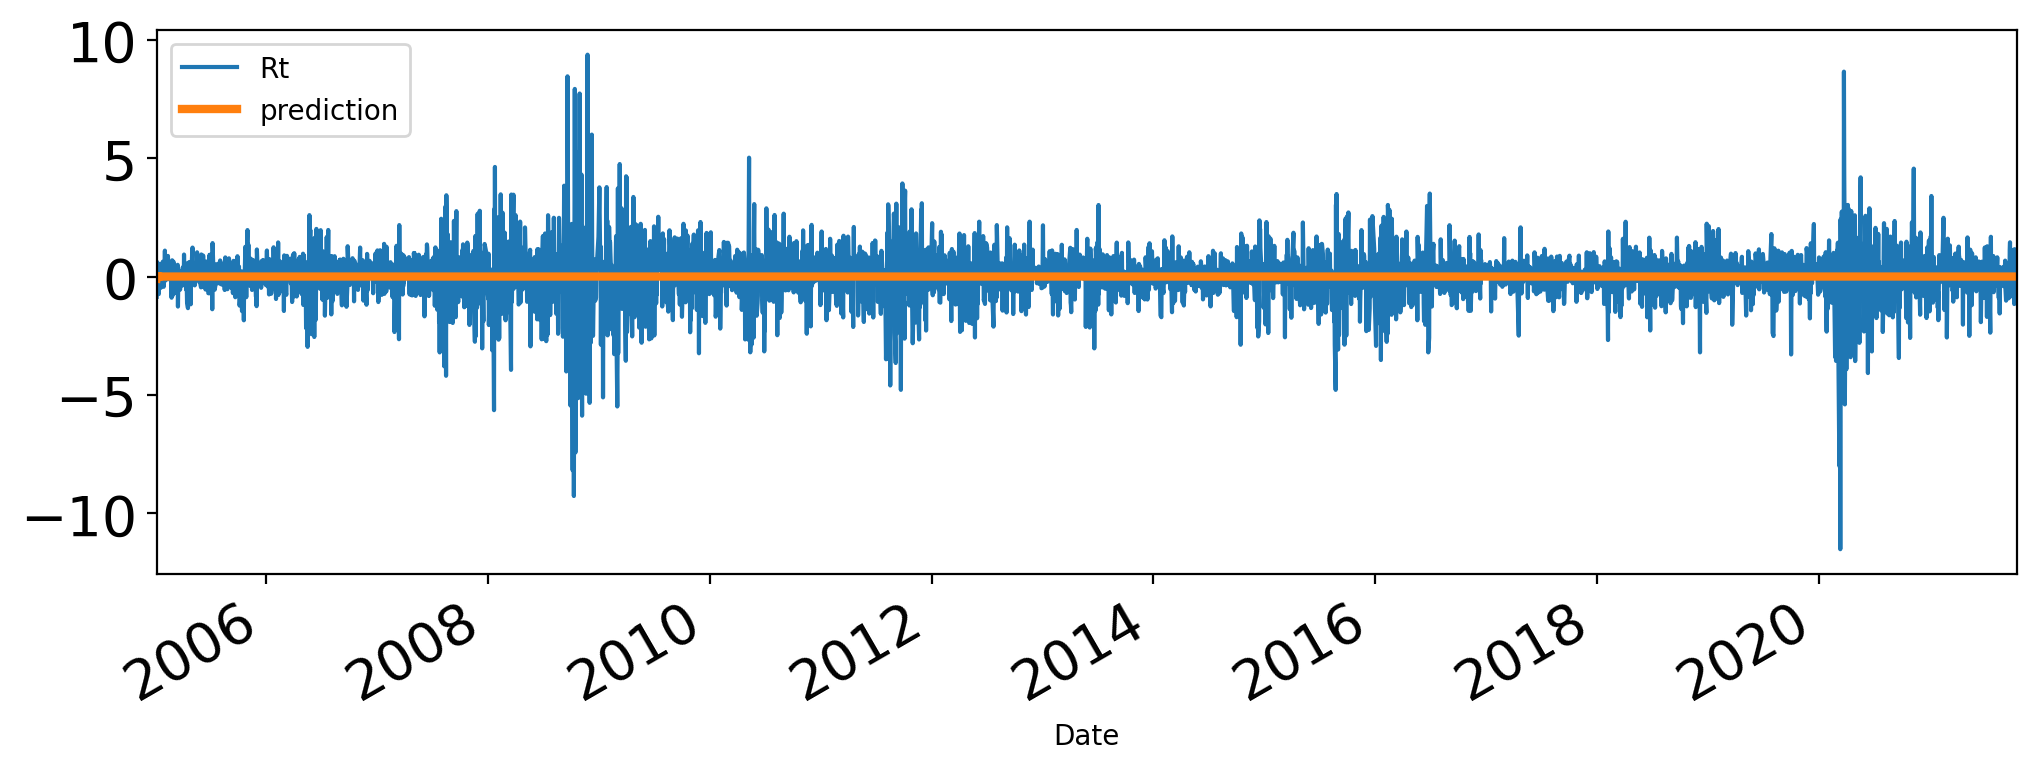

In [379]:
# Evaluation
%reload_ext autoreload
%autoreload 2
Score_ts_arima, Resid_tr_ts_arima, Resid_te_ts_arima = evaluation_trte(df.Rt, pred_tr_ts_arima.values, 
                                                                             df.Rt, pred_te_ts_arima.values, graph_on=True)
display(Score_ts_arima)
ax = pd.DataFrame(df.Rt).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_arima.values, index=df.Rt.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(df.Rt.index.min(),df.Rt.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_arima_ci, index=df.Rt.index).index,
                pd.DataFrame(pred_te_ts_arima_ci, index=df.Rt.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_arima_ci, index=df.Rt.index).iloc[:,1], color='k', alpha=0.5)
plt.show()

However, Residual shows too much volatility. We need to try to predict this. <br>
만약 데이터가 추세나 0이 아닌 평균 등을 가지고 있었다면, ARIMA와 GARCH를 섞어 보는 등의 시도를 할 수 있지만, 지금은 GARCH를 바로 써볼 수 있을 것 같다. 

# GARCH Model

In [380]:
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<AxesSubplot:xlabel='Date'>

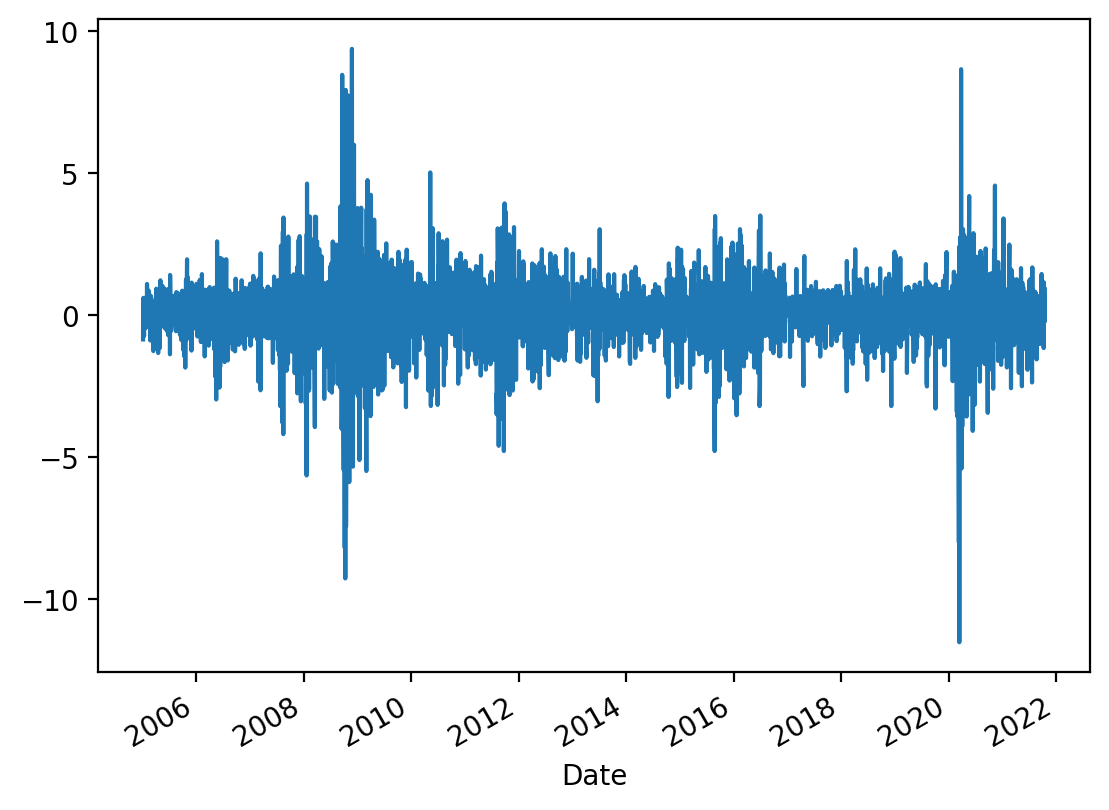

In [381]:
df.Rt.plot()

In [383]:
# Fit GARCH model
_garch_model = arch_model(df.Rt, mean='Zero', p=1, q=1)
_garch_result = _garch_model.fit(disp = 'off')
print(_garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                     Rt   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5697.49
Distribution:                  Normal   AIC:                           11401.0
Method:            Maximum Likelihood   BIC:                           11420.0
                                        No. Observations:                 4226
Date:                Sun, Dec 12 2021   Df Residuals:                     4226
Time:                        18:27:11   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0201  5.681e-03      3.537  4.049e-04 [8.

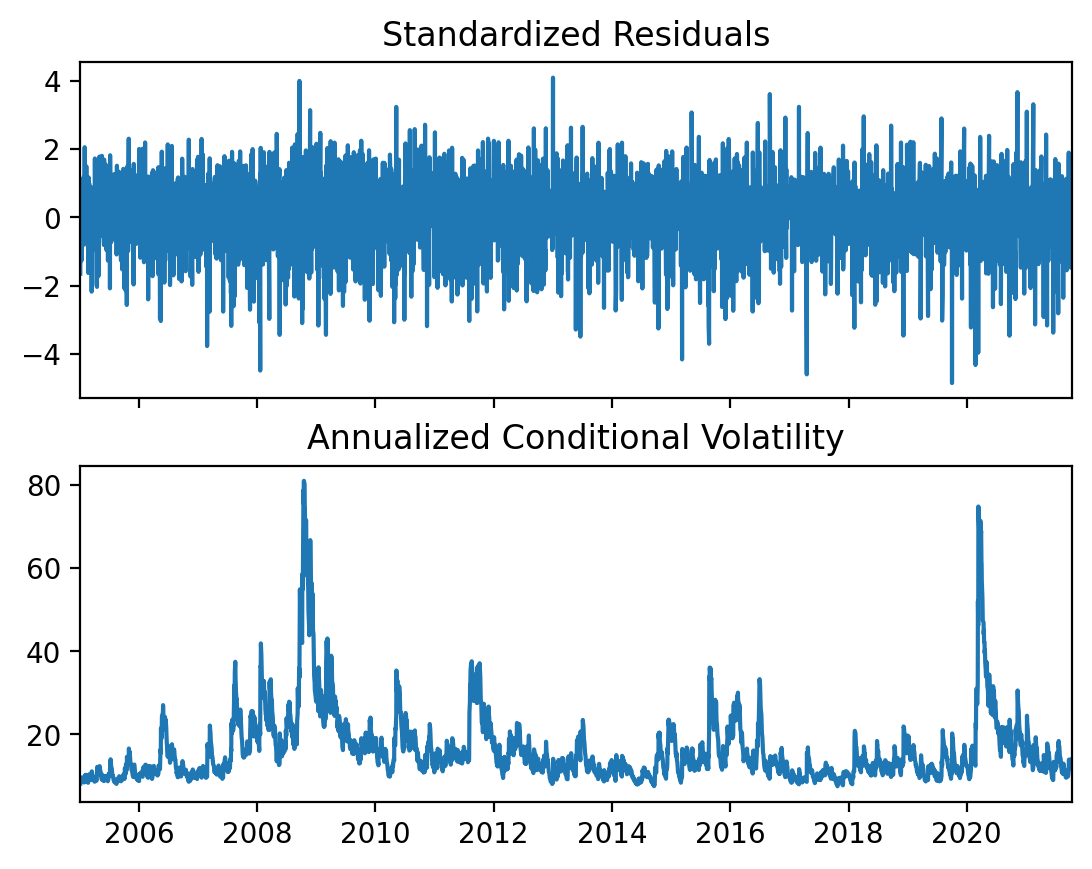

In [384]:
fig = _garch_result.plot(annualize="D")

In [385]:
am = arch_model(df.Rt, p=2, o=1, q=2, power=1.0, mean="zero", dist="Normal")
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     48,   Neg. LLF: 5598.985069167541
Iteration:     10,   Func. Count:     88,   Neg. LLF: 5589.856674905075
Iteration:     15,   Func. Count:    123,   Neg. LLF: 5588.203122791355
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5588.203122784127
            Iterations: 15
            Function evaluations: 123
            Gradient evaluations: 15
                    Zero Mean - TARCH/ZARCH Model Results                     
Dep. Variable:                     Rt   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:               -5588.20
Distribution:                  Normal   AIC:                           11188.4
Method:            Maximum Likelihood   BIC:                           11226.5
                                        No. Observations:                 4226
Date:                

<AxesSubplot:xlabel='Date'>

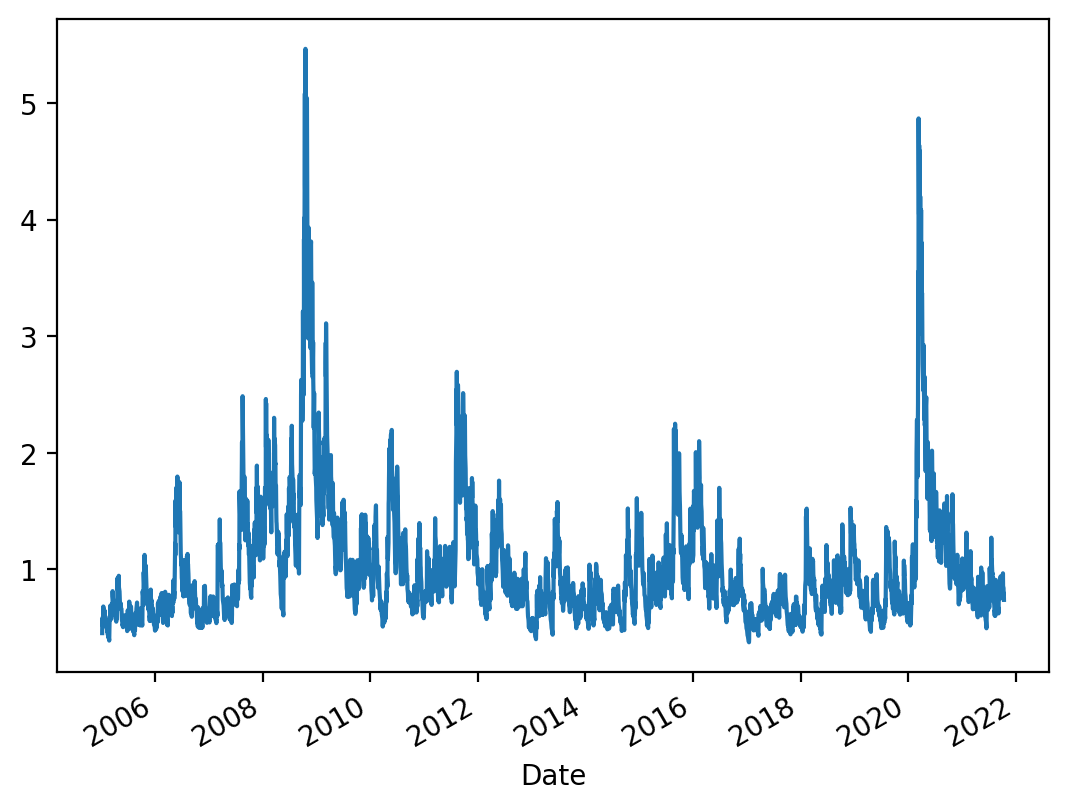

In [386]:
res.conditional_volatility.plot()

<AxesSubplot:xlabel='Date'>

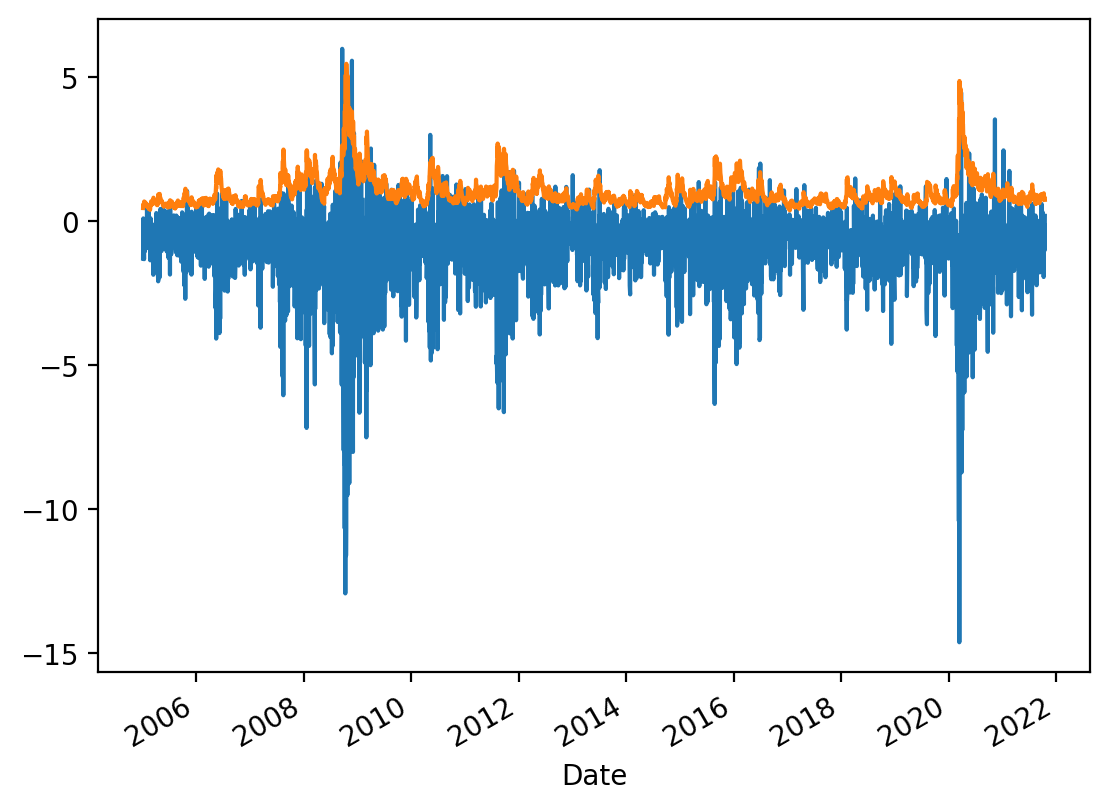

In [387]:
(df.Rt - res.conditional_volatility).plot()
res.conditional_volatility.plot()

In [388]:
new_resid = df.Rt - res.conditional_volatility

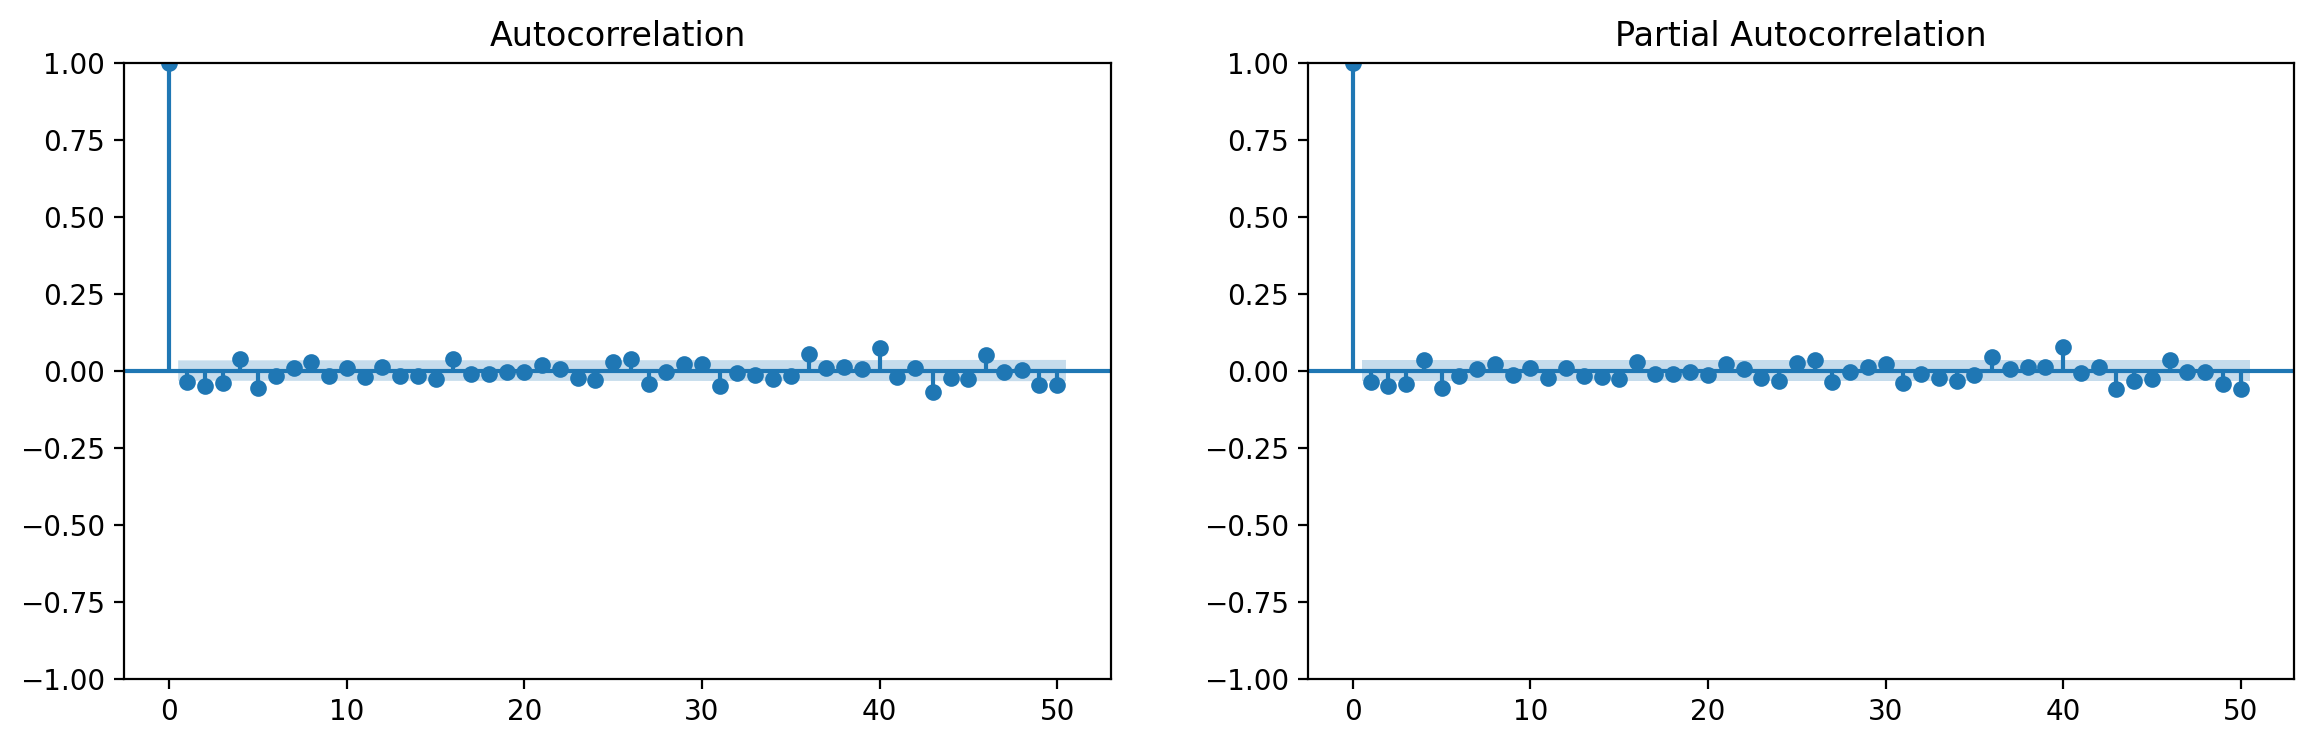

In [389]:
plt.figure(figsize=(14,4))
sm.tsa.graphics.plot_acf(Y_train, lags=50, alpha=0.05, use_vlines=True, ax=plt.subplot(121))
sm.tsa.graphics.plot_pacf(Y_train, lags=50, alpha=0.05, use_vlines=True, ax=plt.subplot(122))
plt.show()

In [391]:
stationarity_adf_test(new_resid, [])

,Stationarity_adf
Test Statistics,-6.887567e+00
p-value,1.381992e-09
Used Lag,2.600000e+01
Used Observations,4.199000e+03
Critical Value(1%),-3.431908e+00
Maximum Information Criteria,1.323006e+04


In [390]:
stationarity_kpss_test(new_resid, [])

,Stationarity_kpss
Test Statistics,0.372118
p-value,0.089173
Used Lag,33.000000
Critical Value(10%),0.347000


Train/Test

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

In [43]:
df.index = df["Date"]
df = df.drop("Date", axis=1)

In [46]:
candidate = df.copy()
split_date ='2019-1-1'
train = candidate[df.index < split_date]["Rt"]
test = candidate[df.index >= split_date]["Rt"]

In [48]:
model = arch_model(train, p=2, q=2)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 42508.5907165017
Iteration:      2,   Func. Count:     20,   Neg. LLF: 19478.141359459314
Iteration:      3,   Func. Count:     31,   Neg. LLF: 6664.3661839633305
Iteration:      4,   Func. Count:     41,   Neg. LLF: 1093454565.7771263
Iteration:      5,   Func. Count:     49,   Neg. LLF: 4775.434707338461
Iteration:      6,   Func. Count:     57,   Neg. LLF: 4754.82325295925
Iteration:      7,   Func. Count:     65,   Neg. LLF: 4718.404737520145
Iteration:      8,   Func. Count:     73,   Neg. LLF: 4693.800548496375
Iteration:      9,   Func. Count:     81,   Neg. LLF: 4692.804028792096
Iteration:     10,   Func. Count:     89,   Neg. LLF: 4694.398517068335
Iteration:     11,   Func. Count:     97,   Neg. LLF: 4691.80302676416
Iteration:     12,   Func. Count:    104,   Neg. LLF: 4691.8728541626415
Iteration:     13,   Func. Count:    112,   Neg. LLF: 4691.738495934975
Iteration:     14,   Func. Count:    119,   Neg. LLF: 4691.7372

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                     Rt   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4691.74
Distribution:                  Normal   AIC:                           9395.47
Method:            Maximum Likelihood   BIC:                           9432.47
                                        No. Observations:                 3521
Date:                Sun, Dec 12 2021   Df Residuals:                     3520
Time:                        16:22:18   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0404  1.382e-02      2.921  3.495e-03 [1.328e-02,6.746e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0259  1.127e-02      2.300  2.145e-02 [3.833e-03,4.802e-02]
alpha[1]       0.1211  2.549e-02      4.750  2.035e-06   [7.111e-02,  0.171]
alpha[2]       0.0424  5.137e-02      0.826      0.409  [-5.828e-02,  0.143]
beta[1]        0.3567      0.265      1.347      0.178     [ -0.162,  0.876]
beta[2]        0.4597      0.222      2.073  3.819e-02   [2.503e-02,  0.894]
============================================================================

Covariance estimator: robust
"""

In [49]:
test_size = len(test)

In [50]:
predictions = model_fit.forecast(horizon=test_size)

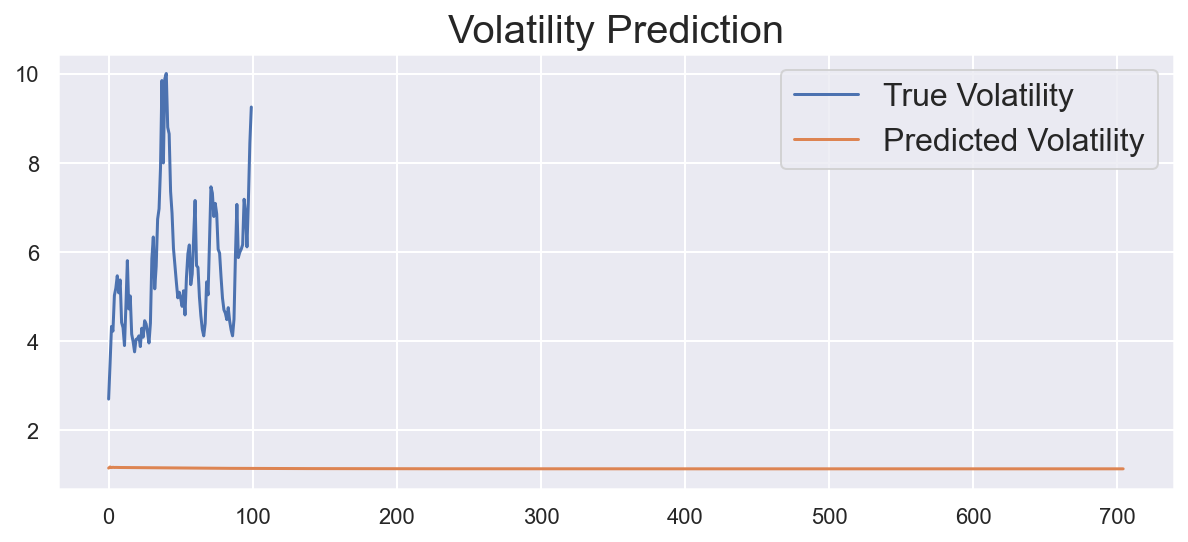

In [54]:
plt.figure(figsize=(10,4))
true, = plt.plot(vols[-test_size:])
preds, = plt.plot(np.sqrt(predictions.variance.values[-1, :]))
plt.title('Volatility Prediction', fontsize=20)
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

In [53]:
new_vol

9.251188624330986

## Smoothing

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


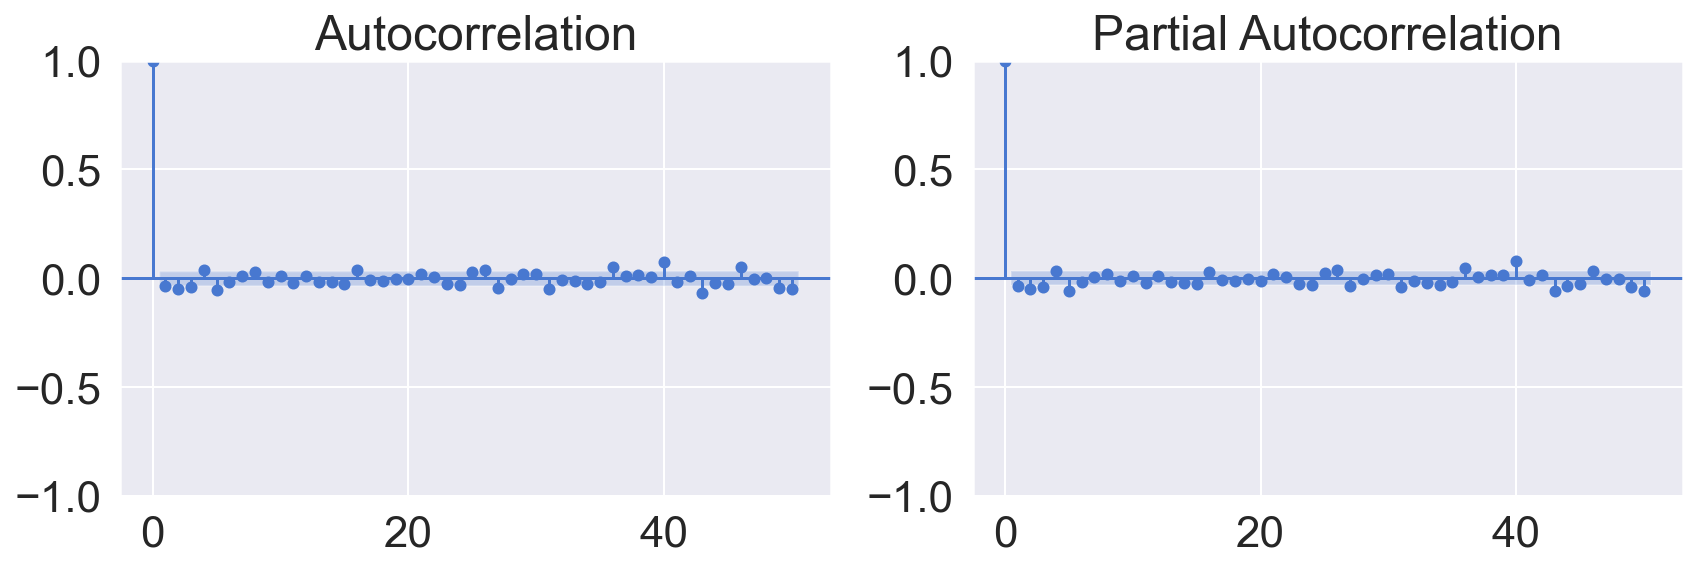

In [174]:
plt.figure(figsize=(14,4))
sm.tsa.graphics.plot_acf(Y_train, lags=50, alpha=0.05, use_vlines=True, ax=plt.subplot(121))
sm.tsa.graphics.plot_pacf(Y_train, lags=50, alpha=0.05, use_vlines=True, ax=plt.subplot(122))
plt.show()

In [175]:
model = sm.tsa.arima.ARIMA(Y_train, order = (2, 0, 3)).fit()
display(model.summary())
pred_tr_ts_arima = model.predict()
pred_te_ts_arima = model.get_forecast(len(Y_test)).predicted_mean
pred_te_ts_arima_ci = model.get_forecast(len(Y_test)).conf_int()

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     Rt   No. Observations:                 3521
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -5434.367
Date:                Sat, 04 Dec 2021   AIC                          10882.735
Time:                        18:24:43   BIC                          10925.900
Sample:                             0   HQIC                         10898.136
                               - 3521                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0093      0.018      0.504      0.614      -0.027       0.045
ar.L1         -0.7127      0.086     -8.299      0.000      -0.881      -0.544
ar.L2         -0.5323      0.084     -6.312      0.000      -0.698      -0.367
ma.L1          0.6759      0.088      7.685      0.000       0.504       0.848
ma.L2          0.4549      0.086      5.274      0.000       0.286       0.624
ma.L3         -0.0882      0.011     -8.330      0.000      -0.109      -0.067
sigma2         1.2827      0.015     83.526      0.000       1.253       1.313
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              8776.87
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [190]:
pd.DataFrame(pred_te_ts_arima.values, index=Y_test.index, columns=['prediction'])

,prediction
Date,
2019-01-02,-0.032740
2019-01-03,-0.148775
2019-01-04,0.153211
2019-01-07,-0.009144
2019-01-08,-0.054163
...,...
2021-10-08,0.009295
2021-10-11,0.009295
2021-10-12,0.009295


/var/folders/zv/bq3zr8t97_12jyw8m8jbgwyc0000gn/T/ipykernel_88629/3644300712.py:15: RuntimeWarning: divide by zero encountered in true_divide
  MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()


,MAE,MSE,MAPE
Train,0.773282,1.282677,inf
Test,0.817031,1.620452,2.716152


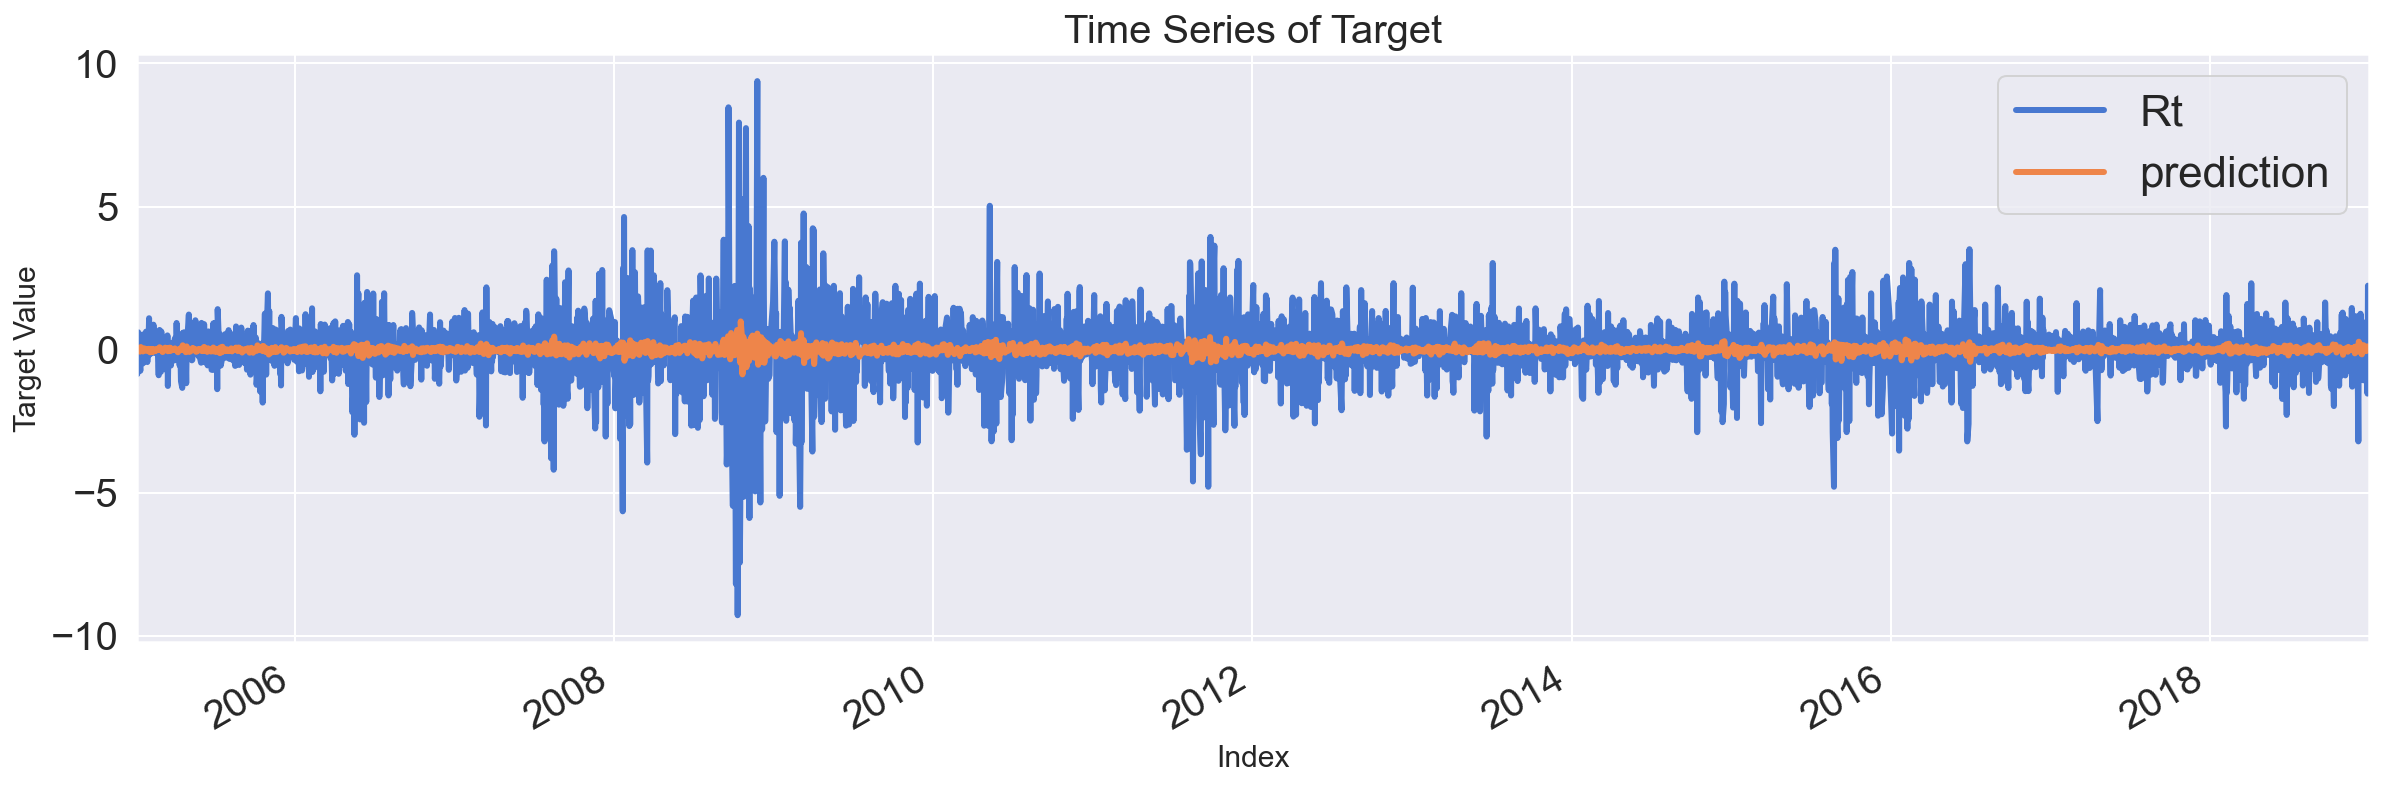

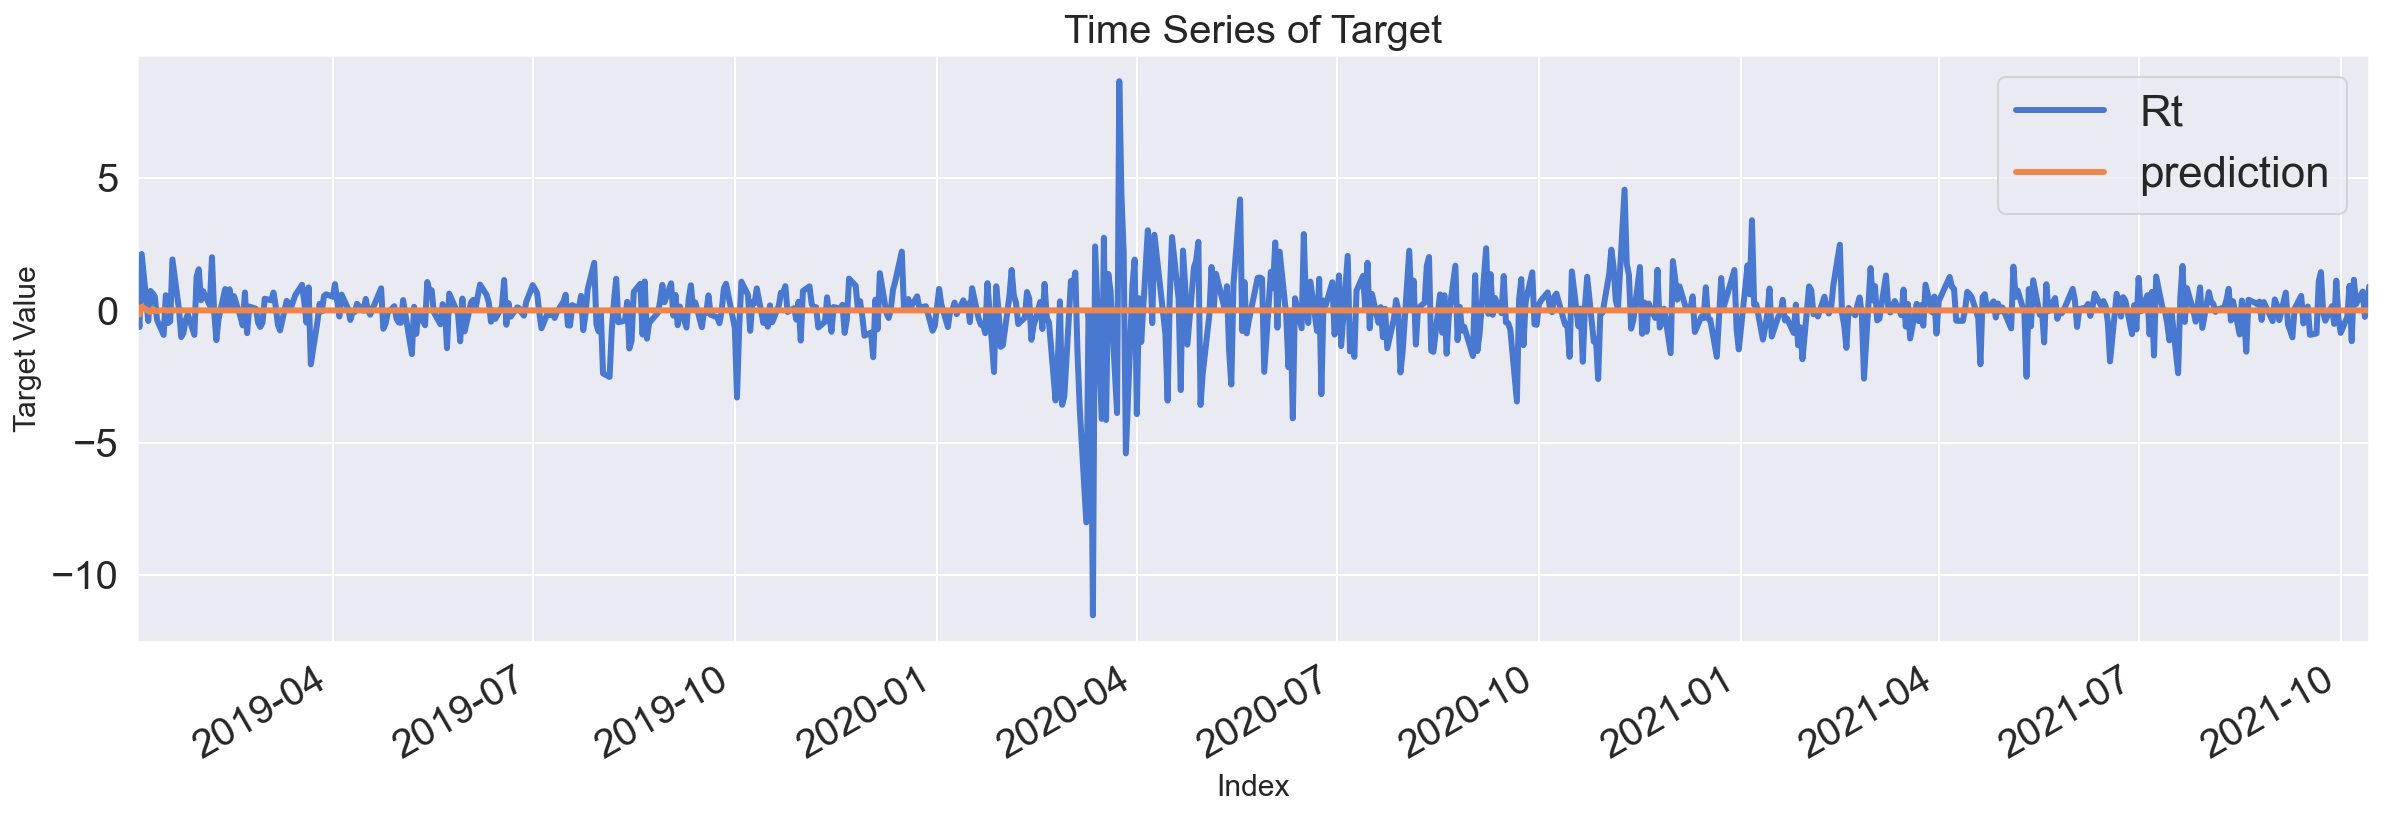

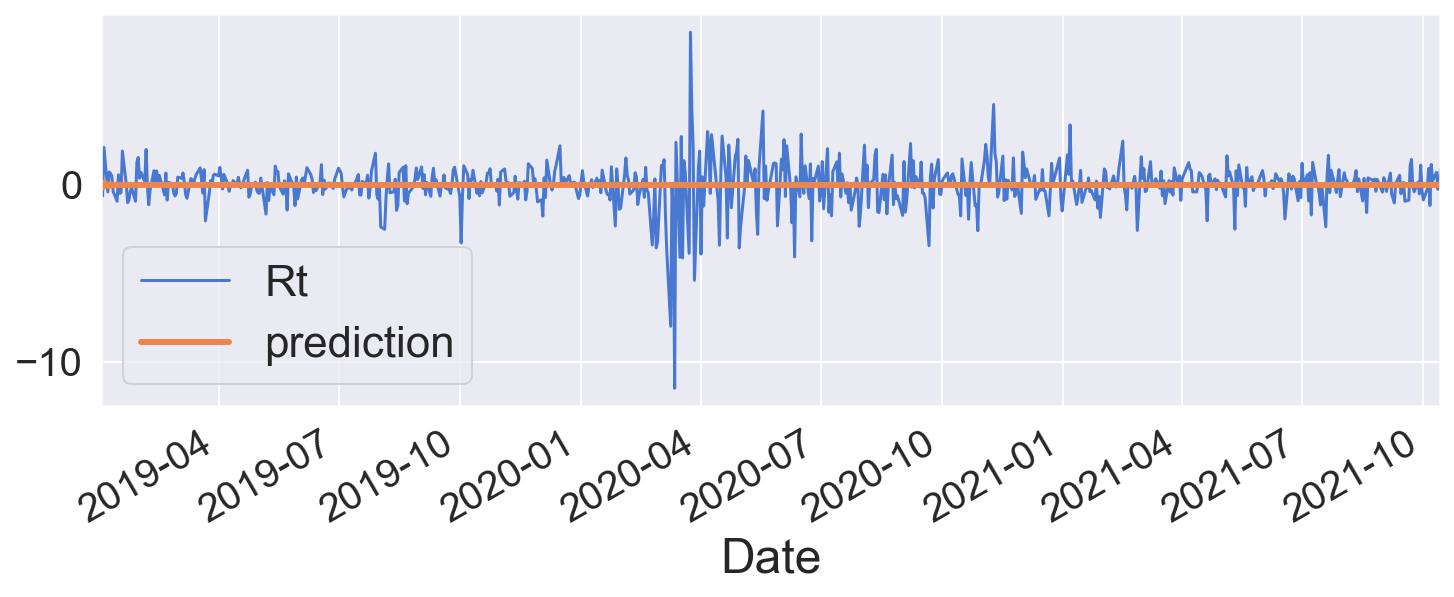

In [192]:
# Evaluation
%reload_ext autoreload
%autoreload 2
Score_ts_arima, Resid_tr_ts_arima, Resid_te_ts_arima = evaluation_trte(Y_train, pred_tr_ts_arima.values, 
                                                                             Y_test, pred_te_ts_arima.values, graph_on=True)
display(Score_ts_arima)
ax = pd.DataFrame(Y_test).plot(figsize=(12,4))
pd.DataFrame(pred_te_ts_arima.values, index=Y_test.index, columns=['prediction']).plot(kind='line',
                                                                           xlim=(Y_test.index.min(),Y_test.index.max()),
                                                                           linewidth=3, fontsize=20, ax=ax)
ax.fill_between(pd.DataFrame(pred_te_ts_arima_ci, index=Y_test.index).index,
                pd.DataFrame(pred_te_ts_arima_ci, index=Y_test.index).iloc[:,0],
                pd.DataFrame(pred_te_ts_arima_ci, index=Y_test.index).iloc[:,1], color='k', alpha=0.5)
plt.show()

Residual Analysis

Resid Plot

<AxesSubplot:xlabel='Date'>

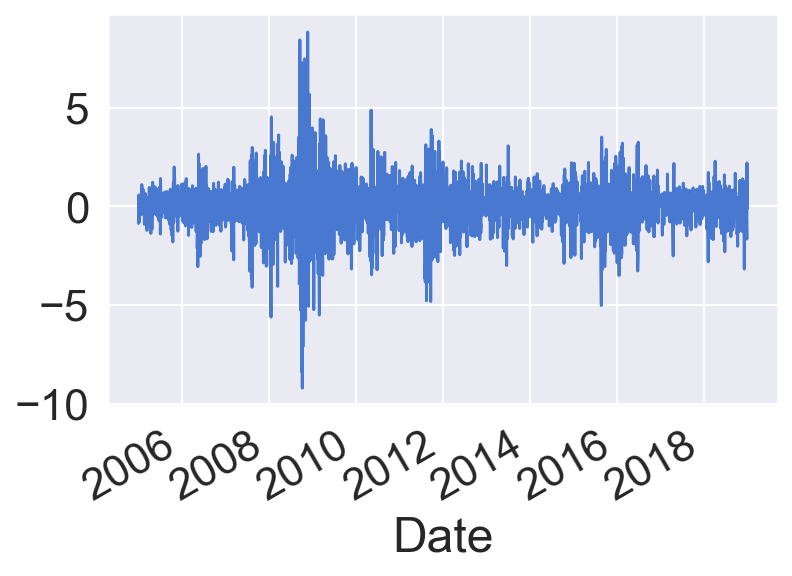

In [201]:
model.resid.plot()

(array([0.00078878, 0.        , 0.00078878, 0.        , 0.        ,
        0.00078878, 0.        , 0.        , 0.        , 0.00157756,
        0.00315513, 0.00394391, 0.00157756, 0.00078878, 0.00394391,
        0.00709904, 0.00788782, 0.01419808, 0.03391764, 0.02839616,
        0.05521475, 0.0930763 , 0.1553901 , 0.23978979, 0.40858919,
        0.53006165, 0.46143759, 0.32418949, 0.16564426, 0.09386508,
        0.05127084, 0.03470642, 0.01498686, 0.01656443, 0.00709904,
        0.00473269, 0.00315513, 0.00236635, 0.00157756, 0.00078878,
        0.        , 0.00078878, 0.        , 0.        , 0.        ,
        0.00078878, 0.00078878, 0.        , 0.00078878, 0.00078878]),
 array([-9.18799198, -8.82793033, -8.46786868, -8.10780703, -7.74774538,
        -7.38768373, -7.02762208, -6.66756043, -6.30749878, -5.94743713,
        -5.58737548, -5.22731383, -4.86725218, -4.50719053, -4.14712888,
        -3.78706723, -3.42700558, -3.06694393, -2.70688228, -2.34682063,
        -1.98675898, -1.62

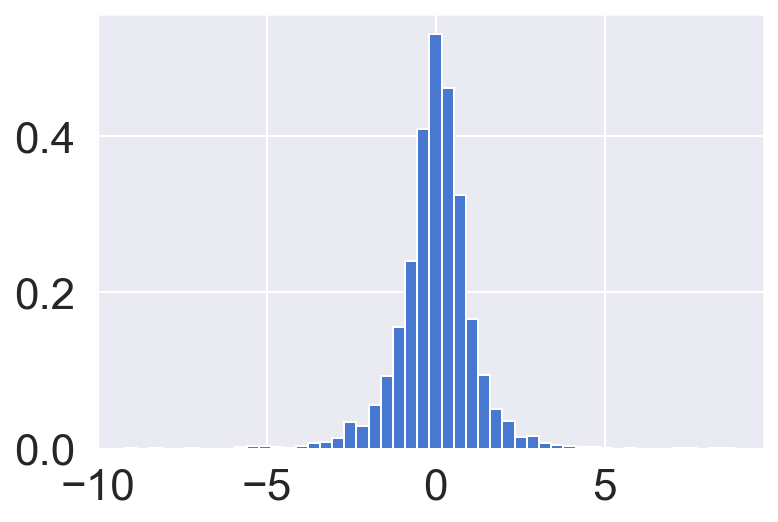

In [205]:
plt.hist(model.resid, density=True, bins = 50)

Stationary Test

In [198]:
Stationarity_adf_resid = stationarity_adf_test(model.resid, [])
Stationarity_kpss_resid = stationarity_kpss_test(model.resid, [])

/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2002: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/sanghyuk/anaconda/envs/py38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2002: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [199]:
Stationarity_adf_resid

,Stationarity_adf
Test Statistics,-59.307157
p-value,0.000000
Used Lag,0.000000
Used Observations,3520.000000
Critical Value(1%),-3.432209
Maximum Information Criteria,10802.432037


In [200]:
Stationarity_kpss_resid

,Stationarity_kpss
Test Statistics,0.043723
p-value,0.100000
Used Lag,13.000000
Critical Value(10%),0.347000


Normality Test

In [197]:
Normality = pd.DataFrame([stats.shapiro(model.resid)],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T
Normality

,Normality
Test Statistics,9.206363e-01
p-value,1.271666e-39


Autocorrelation Test

In [195]:
Autocorrelation = sm.stats.diagnostic.acorr_ljungbox(model.resid, lags=[1,5,10,50])
Autocorrelation = Autocorrelation.T
Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']
Autocorrelation = Autocorrelation.rename(index = {'lb_stat':'Test Statistics', 'lb_pvalue':'p-value'})
Autocorrelation

,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50)
Test Statistics,0.000107,5.969940,10.522352,1.314762e+02
p-value,0.991733,0.309155,0.395920,2.998776e-09
